In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wandb -qU

In [ ]:
!pip install --upgrade wandb

In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: fangyua (fangyua-univeristy-of-michigan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [52]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from tqdm import tqdm
import random

In [53]:
# hyperparameter
# a sequence is like "11+1=12"
batch_size = 32 # there are batch_size sequences in one batch, each sequence contains block_size tokens, each token is mapped to a n_embd vector
block_size = 22 # maximum sequence length, padding ensures that every sequence in a batch must has length of block_size
n_embd = 128 # each token is mapped to a 256-dimensional vector
n_head = 32
n_layer = 8
max_iters = 84800
dropout = 0.1
num_samples = 1000
max_new_tokens = 10 # for 6 digits addition
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 20
bias = True

In [54]:
wandb.init(
    project="transformer_arithmetic_wandb",
    config={
        "max_iters": 84800,
        "num_samples": 1000,
        "phase_2": [0.5, 0.5],
        "phase_3": [0.25, 0.35, 0.40],
        "phase_4": [0.1, 0.3, 0.3, 0.30],
        "phase_5": [0.15, 0.2, 0.2, 0.2, 0.25],
        "phase_6": [0.05, 0.075, 0.1, 0.15, 0.25, 0.375],
        "phase_1 iter": 1000,
        "phase_2 iter": 3000,
        "phase_3 iter": 6000,
        "phase_4 iter": 15000,
        "phase_5 iter": 20000,
        "phase_6 iter": 23000,
        "mixed_digits iter": 16000,
        "phase_train_distribution":[0.05,0.1,0.2,0.2,0.25,0.2],
        "n_embd": 128,
        "n_head": 32,
        "n_layer": 8

    }
)

In [55]:
# Define characters and mappings
# <pad>: 0, <eos>: 13
chars = ["<pad>", "+", "=", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "<eos>"]  # Add padding token
stoi = {ch: i for i, ch in enumerate(chars)}  # Character-to-index mapping
itos = {i: ch for ch, i in stoi.items()}  # Index-to-character mapping
padding_idx = stoi["<pad>"]  # Index for the padding token
eos_idx = stoi["<eos>"]
vocab_size = len(chars)

In [56]:
# Encode and decode functions
def encode(seq):
    return [stoi[ch] for ch in seq]

def decode(indices):
    return ''.join([itos[idx] for idx in indices])


In [57]:
# 6-digits online sampling
digit_ranges = {
    1: (0, 9),
    2: (10, 99),
    3: (100, 999),
    4: (1000, 9999),
    5: (10000, 99999),
    6: (100000, 999999),
    7: (1000000, 9999999)
}

digit_distribution = {
    1: [1],
    2: [0.5, 0.5],
    3: [0.25, 0.35, 0.4],
    4: [0.1, 0.3, 0.3, 0.3],
    5: [0.15, 0.2, 0.2, 0.2, 0.25],
    6: [0.05, 0.075, 0.1, 0.15, 0.25, 0.375],
    7: [0.025, 0.05, 0.1, 0.15, 0.15, 0.25, 0.275]
}

# generate certain digits number: sample_number(3) outputs 3-digits number: 754
def sample_number(digit_distribution):
  lower_bound, higher_bound = digit_ranges[digit_distribution]
  return np.random.randint(lower_bound, higher_bound+1)

def generate_equation(phase):

    if phase == 1:
        left_digit = 1
        right_digit = 1
    else:
        distribution = digit_distribution[phase]
        choices = list(range(1, phase + 1))
        left_digit = np.random.choice(choices, p=distribution)
        right_digit = phase

    # Sample the actual numbers:
    a = sample_number(left_digit)
    b = sample_number(right_digit)

    result_normal = a + b
    result = str(result_normal)[::-1]
    equation_str = f"{a}+{b}={result}"

    # Convert the equation string into token IDs.
    equation_ids = [stoi[ch] for ch in equation_str]
    equation_ids.append(stoi["<eos>"])

    return equation_ids


In [58]:
# test for generate_equation()
for _ in range(5):
  print(decode(generate_equation(2)))

31+43=47<eos>
88+56=441<eos>
5+15=02<eos>
47+32=97<eos>
67+65=231<eos>


In [59]:
def pad_sequence(sequence, block_size, padding_idx):
    if len(sequence) < block_size:
        sequence += [padding_idx] * (block_size - len(sequence))  # Add <pad> tokens
    return sequence

def get_batch(batch_size, phase, block_size):
    batch_ids = [generate_equation(phase) for _ in range(batch_size)]

    batch_encoded = [
        pad_sequence(seq, block_size, padding_idx)
        for seq in batch_ids
    ]

    x = torch.tensor([seq[:-1] for seq in batch_encoded], dtype=torch.long)
    y = torch.tensor([seq[1:] for seq in batch_encoded], dtype=torch.long)
    return x.to(device), y.to(device)

In [60]:
@torch.no_grad()
def estimate_loss(phase):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(batch_size, phase, block_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [61]:
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias=True): # class constructor
        super().__init__()
        # nn.Parameter, pytorch optimize will update the value of this parameter during training
        self.weight = nn.Parameter(torch.ones(ndim)) # trainable parameter
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None # trainable parameter

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size, bias=True):
        super().__init__()
        assert n_embd % n_head == 0, "Embedding dimension must be divisible by the number of heads."

        # Store hyperparameters
        self.n_head = n_head
        self.n_embd = n_embd
        self.dropout = dropout
        self.block_size = block_size

        # Key, Query, Value projections
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=bias)
        # Output projection
        self.c_proj = nn.Linear(n_embd, n_embd, bias=bias)
        # Regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

        # Check for Flash Attention availability
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # Causal mask for slow attention
            self.register_buffer(
                "bias",
                torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size)
            )

    def forward(self, x):
        B, T, C = x.size()  # Batch size, sequence length, embedding dimension

        # Compute Q, K, V
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)  # Split into Q, K, V (B, T, n_embd)

        # Reshape for multi-head attention
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, n_head, T, head_size)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, n_head, T, head_size)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, n_head, T, head_size)

        # Flash Attention or fallback to manual implementation
        if self.flash:
            y = torch.nn.functional.scaled_dot_product_attention(
                q, k, v,
                attn_mask=None,
                dropout_p=self.dropout if self.training else 0,
                is_causal=True
            )
        else:
            # Manual attention with causal masking
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))  # Scaled dot product
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))  # Apply causal mask
            att = F.softmax(att, dim=-1)  # Normalize attention scores
            att = self.attn_dropout(att)
            y = att @ v  # Apply attention weights to values (B, n_head, T, head_size)

        # Reshape back to original format
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # Reassemble heads

        # Output projection and residual dropout
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module): # FFN

    def __init__(self, n_embd, dropout, bias=True):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd, bias=bias)
        self.gelu    = nn.GELU() # nonlinear activation function
        self.c_proj  = nn.Linear(4 * n_embd, n_embd, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size, bias=True):
        super().__init__()
        # LayerNorm and CausalSelfAttention with explicit parameters
        self.ln_1 = LayerNorm(n_embd, bias=bias)
        self.attn = CausalSelfAttention(n_embd, n_head, dropout, block_size, bias=bias)
        self.ln_2 = LayerNorm(n_embd, bias=bias)
        self.mlp = MLP(n_embd, dropout, bias=bias)  # MLP with explicit parameters

    def forward(self, x):
        # Apply residual connection and pre-normalization
        x = x + self.attn(self.ln_1(x))  # Apply LayerNorm before attention
        x = x + self.mlp(self.ln_2(x))  # Apply LayerNorm before MLP
        return x

In [62]:
class GPT(nn.Module):

    def __init__(self, vocab_size, block_size, n_embd, n_layer, n_head, dropout, bias=True):
        super().__init__()
        assert vocab_size is not None
        assert block_size is not None
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.dropout = dropout
        self.bias = bias

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, n_embd), # token embeddings
            wpe = nn.Embedding(block_size, n_embd), # positional embeddings
            drop = nn.Dropout(dropout),
            h = nn.ModuleList([Block(n_embd, n_head, dropout, block_size, bias=bias) for _ in range(n_layer)]), # a stack of n_layer blocks
            ln_f = LayerNorm(n_embd, bias=bias), # final layer norm
        ))
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False) # projects the final transformer output to the vocab size

        # init all weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.cblock_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=padding_idx)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=0.2, top_k=1):
        for _ in range(max_new_tokens):
            # prepare the input
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]

            # forward pass through the model
            logits, _ = self(idx_cond)
            # scale the logits for the last token only
            logits = logits[:, -1, :] / temperature

            # keep only the top_k tokens and set others to -inf
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')

            # convert logits into probs
            probs = F.softmax(logits, dim=-1)
            # sample the next token from multinomial distribtuion
            idx_next = torch.multinomial(probs, num_samples=1)

            # break generate if reach <eos> for all sequence
            if (idx_next == eos_idx).all():
              break

            idx = torch.cat((idx, idx_next), dim=1)

        return idx


In [64]:
phase_1_iter = 1000
phase_2_iter = 3000
phase_3_iter = 6000
phase_4_iter = 12000
phase_5_iter = 14000
phase_6_iter = 14000

phase_1_end = phase_1_iter
phase_2_end = phase_1_end + phase_2_iter      # = 1000 + 3000  = 4000
phase_3_end = phase_2_end + phase_3_iter      # = 4000 + 5000  = 9000
phase_4_end = phase_3_end + phase_4_iter      # = 9000 + 7000  = 16000
phase_5_end = phase_4_end + phase_5_iter      # = 16000 + 9000 = 25000
phase_6_end = phase_5_end + phase_6_iter      # = 25000 +11000 = 36000

mixed_digit_distribution = [0.05,0.1,0.2,0.2,0.25,0.2]


In [65]:
def get_phase(iter_num, max_iters):
    # Phase 1
    if iter_num < phase_1_end:
        return 1

    # Phase 2
    if iter_num < phase_2_end:
        return 2

    # Phase 3
    if iter_num < phase_3_end:
        return 3

    # Phase 4
    if iter_num < phase_4_end:
        return 4

    # Phase 5
    if iter_num < phase_5_end:
        return 5

    # Phase 6
    if iter_num < phase_6_end:
        return 6

    # After phase 6, final mixed stage
    return np.random.choice([1,2,3,4,5,6], p=mixed_digit_distribution)


In [66]:
phase_1_iter = 1000
phase_2_iter = 3000
phase_3_iter = 6000
phase_4_iter = 15000
phase_5_iter = 20000
phase_6_iter = 23000
phase_2_3_transition = 200
phase_3_4_transition = 200
phase_4_5_transition = 200
phase_5_6_transition = 200


phase_1_end = phase_1_iter
phase_2_end = phase_1_end + phase_2_iter
phase_3_end = phase_2_end + phase_3_iter
phase_4_end = phase_3_end + phase_4_iter
phase_5_end = phase_4_end + phase_5_iter
phase_6_end = phase_5_end + phase_6_iter

mixed_digit_distribution = [0.01,0.04,0.1,0.15,0.3,0.4]

def get_phase(iter_num, max_iters):
    # phase 1 training
    if iter_num < phase_1_end:
        return 1

    # phase 2 training
    if iter_num < phase_2_end:
      return 2

    # phase 2-3 transition
    t_start = phase_2_end
    t_end = phase_2_end + phase_2_3_transition
    if iter_num < t_end:
        fraction = (iter_num - t_start) / (t_end - t_start)
        p2 = 1.0 - fraction
        p3 = fraction
        return np.random.choice([2, 3], p=[p2, p3])

    # phase 3 training:
    if iter_num < phase_3_end + phase_2_3_transition:
        return 3

    # phase 3-4 transition
    t_start = phase_3_end + phase_2_3_transition
    t_end = t_start + phase_3_4_transition
    if iter_num < t_end:
        fraction = (iter_num - t_start) / (t_end - t_start)
        p3 = 1.0 - fraction
        p4 = fraction
        return np.random.choice([3, 4], p=[p3, p4])

    # phase 4 training:
    if iter_num < phase_4_end + phase_2_3_transition + phase_3_4_transition:
        return 4

    # phase 4-5 transition:
    t_start = phase_4_end + phase_2_3_transition + phase_3_4_transition
    t_end = t_start + phase_4_5_transition
    if iter_num < t_end:
        fraction = (iter_num - t_start) / (t_end - t_start)
        p4 = 1.0 - fraction
        p5 = fraction
        return np.random.choice([4, 5], p=[p4, p5])

    # phase 5 training:
    if iter_num < phase_5_end + phase_2_3_transition + phase_3_4_transition + phase_4_5_transition:
        return 5

    # phase 5-6 transition:
    t_start = phase_5_end + phase_2_3_transition + phase_3_4_transition + phase_4_5_transition
    t_end = t_start + phase_5_6_transition
    if iter_num < t_end:
        fraction = (iter_num - t_start) / (t_end - t_start)
        p5 = 1.0 - fraction
        p6 = fraction
        return np.random.choice([5, 6], p=[p5, p6])

    # phase 6 transition:
    if iter_num < phase_6_end + (phase_2_3_transition + phase_3_4_transition + phase_4_5_transition + phase_5_6_transition):
        return 6

    return np.random.choice([1,2,3,4,5,6], p=mixed_digit_distribution)


In [67]:
model = GPT(vocab_size, block_size, n_embd, n_layer, n_head, dropout, bias=bias)
m = model.to(device)


In [69]:
# model training

optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

for iter in tqdm(range(max_iters), desc="Training Progress"):
    phase = get_phase(iter, max_iters)

    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(phase)
        print(f"step {iter}: train loss {losses['train']:.4f} (phase {phase})")
        wandb.log({
            "iteration": iter,
            "eval_loss": losses["train"],
            "phase": phase
        })

    xb, yb = get_batch(batch_size, phase, block_size)

    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    wandb.log({
        "iteration": iter,
        "loss": loss.item(),
        "phase": phase
    })

Training Progress:   0%|          | 8/84800 [00:00<54:40, 25.85it/s]  

step 0: train loss 1.0373 (phase 1)


Training Progress:   0%|          | 113/84800 [00:02<27:43, 50.91it/s]

step 100: train loss 0.4277 (phase 1)


Training Progress:   0%|          | 211/84800 [00:03<27:59, 50.37it/s]

step 200: train loss 0.4239 (phase 1)


Training Progress:   0%|          | 309/84800 [00:05<27:45, 50.75it/s]

step 300: train loss 0.4244 (phase 1)


Training Progress:   0%|          | 407/84800 [00:07<31:03, 45.28it/s]

step 400: train loss 0.4230 (phase 1)


Training Progress:   1%|          | 512/84800 [00:08<27:51, 50.43it/s]

step 500: train loss 0.4231 (phase 1)


Training Progress:   1%|          | 610/84800 [00:10<27:47, 50.50it/s]

step 600: train loss 0.4234 (phase 1)


Training Progress:   1%|          | 708/84800 [00:12<27:36, 50.78it/s]

step 700: train loss 0.4255 (phase 1)


Training Progress:   1%|          | 813/84800 [00:13<27:59, 50.00it/s]

step 800: train loss 0.4236 (phase 1)


Training Progress:   1%|          | 911/84800 [00:15<27:58, 49.98it/s]

step 900: train loss 0.4227 (phase 1)


Training Progress:   1%|          | 1009/84800 [00:17<29:44, 46.96it/s]

step 1000: train loss 2.2140 (phase 2)


Training Progress:   1%|▏         | 1108/84800 [00:19<33:43, 41.37it/s]

step 1100: train loss 0.8198 (phase 2)


Training Progress:   1%|▏         | 1209/84800 [00:20<31:11, 44.66it/s]

step 1200: train loss 0.8128 (phase 2)


Training Progress:   2%|▏         | 1307/84800 [00:22<34:13, 40.65it/s]

step 1300: train loss 0.8148 (phase 2)


Training Progress:   2%|▏         | 1412/84800 [00:24<30:21, 45.79it/s]

step 1400: train loss 0.8088 (phase 2)


Training Progress:   2%|▏         | 1510/84800 [00:26<30:21, 45.72it/s]

step 1500: train loss 0.8101 (phase 2)


Training Progress:   2%|▏         | 1608/84800 [00:28<30:35, 45.33it/s]

step 1600: train loss 0.8082 (phase 2)


Training Progress:   2%|▏         | 1706/84800 [00:29<33:42, 41.08it/s]

step 1700: train loss 0.8033 (phase 2)


Training Progress:   2%|▏         | 1810/84800 [00:31<31:38, 43.72it/s]

step 1800: train loss 0.8103 (phase 2)


Training Progress:   2%|▏         | 1910/84800 [00:33<30:24, 45.44it/s]

step 1900: train loss 0.8056 (phase 2)


Training Progress:   2%|▏         | 2008/84800 [00:35<30:18, 45.52it/s]

step 2000: train loss 0.8117 (phase 2)


Training Progress:   2%|▏         | 2106/84800 [00:37<34:02, 40.49it/s]

step 2100: train loss 0.8098 (phase 2)


Training Progress:   3%|▎         | 2211/84800 [00:39<29:59, 45.89it/s]

step 2200: train loss 0.8079 (phase 2)


Training Progress:   3%|▎         | 2309/84800 [00:40<30:18, 45.36it/s]

step 2300: train loss 0.8101 (phase 2)


Training Progress:   3%|▎         | 2412/84800 [00:42<31:26, 43.68it/s]

step 2400: train loss 0.8092 (phase 2)


Training Progress:   3%|▎         | 2506/84800 [00:44<34:10, 40.12it/s]

step 2500: train loss 0.8077 (phase 2)


Training Progress:   3%|▎         | 2611/84800 [00:46<29:55, 45.77it/s]

step 2600: train loss 0.8067 (phase 2)


Training Progress:   3%|▎         | 2708/84800 [00:48<30:06, 45.45it/s]

step 2700: train loss 0.8058 (phase 2)


Training Progress:   3%|▎         | 2811/84800 [00:50<29:50, 45.78it/s]

step 2800: train loss 0.8096 (phase 2)


Training Progress:   3%|▎         | 2909/84800 [00:51<29:46, 45.84it/s]

step 2900: train loss 0.8072 (phase 2)


Training Progress:   4%|▎         | 3007/84800 [00:53<32:47, 41.56it/s]

step 3000: train loss 0.8031 (phase 2)


Training Progress:   4%|▎         | 3110/84800 [00:55<30:39, 44.40it/s]

step 3100: train loss 0.8123 (phase 2)


Training Progress:   4%|▍         | 3206/84800 [00:57<34:19, 39.62it/s]

step 3200: train loss 0.8081 (phase 2)


Training Progress:   4%|▍         | 3311/84800 [00:59<29:31, 45.99it/s]

step 3300: train loss 0.8078 (phase 2)


Training Progress:   4%|▍         | 3408/84800 [01:00<29:35, 45.85it/s]

step 3400: train loss 0.8073 (phase 2)


Training Progress:   4%|▍         | 3506/84800 [01:02<32:39, 41.48it/s]

step 3500: train loss 0.8098 (phase 2)


Training Progress:   4%|▍         | 3611/84800 [01:04<29:05, 46.51it/s]

step 3600: train loss 0.8032 (phase 2)


Training Progress:   4%|▍         | 3709/84800 [01:06<29:05, 46.45it/s]

step 3700: train loss 0.8117 (phase 2)


Training Progress:   4%|▍         | 3807/84800 [01:08<33:32, 40.25it/s]

step 3800: train loss 0.8068 (phase 2)


Training Progress:   5%|▍         | 3912/84800 [01:09<29:33, 45.60it/s]

step 3900: train loss 0.8097 (phase 2)


Training Progress:   5%|▍         | 4010/84800 [01:11<29:29, 45.64it/s]

step 4000: train loss 0.8095 (phase 2)


Training Progress:   5%|▍         | 4108/84800 [01:13<28:58, 46.42it/s]

step 4100: train loss 0.8800 (phase 2)


Training Progress:   5%|▍         | 4212/84800 [01:15<29:05, 46.18it/s]

step 4200: train loss 1.0498 (phase 3)


Training Progress:   5%|▌         | 4310/84800 [01:17<29:13, 45.90it/s]

step 4300: train loss 1.0133 (phase 3)


Training Progress:   5%|▌         | 4408/84800 [01:18<29:31, 45.39it/s]

step 4400: train loss 1.0110 (phase 3)


Training Progress:   5%|▌         | 4510/84800 [01:20<29:32, 45.28it/s]

step 4500: train loss 1.0077 (phase 3)


Training Progress:   5%|▌         | 4607/84800 [01:22<32:26, 41.19it/s]

step 4600: train loss 1.0023 (phase 3)


Training Progress:   6%|▌         | 4712/84800 [01:24<28:30, 46.81it/s]

step 4700: train loss 1.0029 (phase 3)


Training Progress:   6%|▌         | 4810/84800 [01:26<28:57, 46.05it/s]

step 4800: train loss 1.0056 (phase 3)


Training Progress:   6%|▌         | 4908/84800 [01:27<29:24, 45.28it/s]

step 4900: train loss 1.0050 (phase 3)


Training Progress:   6%|▌         | 5006/84800 [01:29<32:16, 41.21it/s]

step 5000: train loss 1.0092 (phase 3)


Training Progress:   6%|▌         | 5111/84800 [01:31<29:13, 45.45it/s]

step 5100: train loss 1.0091 (phase 3)


Training Progress:   6%|▌         | 5208/84800 [01:33<29:20, 45.20it/s]

step 5200: train loss 1.0065 (phase 3)


Training Progress:   6%|▋         | 5308/84800 [01:35<28:53, 45.87it/s]

step 5300: train loss 1.0062 (phase 3)


Training Progress:   6%|▋         | 5406/84800 [01:36<32:38, 40.54it/s]

step 5400: train loss 1.0107 (phase 3)


Training Progress:   6%|▋         | 5511/84800 [01:38<28:56, 45.65it/s]

step 5500: train loss 1.0085 (phase 3)


Training Progress:   7%|▋         | 5609/84800 [01:40<28:27, 46.39it/s]

step 5600: train loss 1.0093 (phase 3)


Training Progress:   7%|▋         | 5707/84800 [01:42<31:31, 41.82it/s]

step 5700: train loss 1.0077 (phase 3)


Training Progress:   7%|▋         | 5812/84800 [01:44<29:50, 44.11it/s]

step 5800: train loss 1.0108 (phase 3)


Training Progress:   7%|▋         | 5907/84800 [01:46<30:55, 42.52it/s]

step 5900: train loss 1.0110 (phase 3)


Training Progress:   7%|▋         | 6012/84800 [01:47<29:06, 45.12it/s]

step 6000: train loss 1.0131 (phase 3)


Training Progress:   7%|▋         | 6110/84800 [01:49<28:44, 45.64it/s]

step 6100: train loss 1.0109 (phase 3)


Training Progress:   7%|▋         | 6208/84800 [01:51<28:27, 46.03it/s]

step 6200: train loss 1.0102 (phase 3)


Training Progress:   7%|▋         | 6306/84800 [01:53<31:34, 41.44it/s]

step 6300: train loss 1.0076 (phase 3)


Training Progress:   8%|▊         | 6411/84800 [01:55<29:40, 44.03it/s]

step 6400: train loss 1.0083 (phase 3)


Training Progress:   8%|▊         | 6508/84800 [01:56<28:43, 45.43it/s]

step 6500: train loss 1.0073 (phase 3)


Training Progress:   8%|▊         | 6606/84800 [01:58<31:42, 41.11it/s]

step 6600: train loss 1.0127 (phase 3)


Training Progress:   8%|▊         | 6711/84800 [02:00<28:23, 45.84it/s]

step 6700: train loss 1.0083 (phase 3)


Training Progress:   8%|▊         | 6809/84800 [02:02<28:02, 46.35it/s]

step 6800: train loss 1.0092 (phase 3)


Training Progress:   8%|▊         | 6907/84800 [02:04<32:04, 40.47it/s]

step 6900: train loss 1.0105 (phase 3)


Training Progress:   8%|▊         | 7012/84800 [02:05<28:25, 45.60it/s]

step 7000: train loss 1.0129 (phase 3)


Training Progress:   8%|▊         | 7110/84800 [02:07<28:01, 46.21it/s]

step 7100: train loss 1.0071 (phase 3)


Training Progress:   8%|▊         | 7208/84800 [02:09<28:54, 44.73it/s]

step 7200: train loss 1.0051 (phase 3)


Training Progress:   9%|▊         | 7311/84800 [02:11<28:25, 45.43it/s]

step 7300: train loss 1.0048 (phase 3)


Training Progress:   9%|▊         | 7409/84800 [02:13<28:02, 46.01it/s]

step 7400: train loss 1.0188 (phase 3)


Training Progress:   9%|▉         | 7507/84800 [02:14<31:00, 41.54it/s]

step 7500: train loss 1.0093 (phase 3)


Training Progress:   9%|▉         | 7612/84800 [02:16<28:31, 45.10it/s]

step 7600: train loss 1.0143 (phase 3)


Training Progress:   9%|▉         | 7710/84800 [02:18<28:19, 45.35it/s]

step 7700: train loss 1.0100 (phase 3)


Training Progress:   9%|▉         | 7808/84800 [02:20<27:38, 46.42it/s]

step 7800: train loss 1.0024 (phase 3)


Training Progress:   9%|▉         | 7909/84800 [02:22<28:56, 44.28it/s]

step 7900: train loss 1.0086 (phase 3)


Training Progress:   9%|▉         | 8007/84800 [02:24<30:50, 41.49it/s]

step 8000: train loss 1.0130 (phase 3)


Training Progress:  10%|▉         | 8112/84800 [02:25<27:50, 45.90it/s]

step 8100: train loss 1.0050 (phase 3)


Training Progress:  10%|▉         | 8209/84800 [02:27<28:59, 44.03it/s]

step 8200: train loss 1.0101 (phase 3)


Training Progress:  10%|▉         | 8310/84800 [02:29<27:36, 46.17it/s]

step 8300: train loss 1.0101 (phase 3)


Training Progress:  10%|▉         | 8408/84800 [02:31<27:48, 45.78it/s]

step 8400: train loss 1.0097 (phase 3)


Training Progress:  10%|█         | 8512/84800 [02:33<27:38, 46.00it/s]

step 8500: train loss 1.0102 (phase 3)


Training Progress:  10%|█         | 8606/84800 [02:34<31:25, 40.41it/s]

step 8600: train loss 1.0093 (phase 3)


Training Progress:  10%|█         | 8711/84800 [02:36<27:34, 45.99it/s]

step 8700: train loss 1.0140 (phase 3)


Training Progress:  10%|█         | 8809/84800 [02:38<26:53, 47.09it/s]

step 8800: train loss 1.0138 (phase 3)


Training Progress:  11%|█         | 8907/84800 [02:40<30:46, 41.11it/s]

step 8900: train loss 1.0080 (phase 3)


Training Progress:  11%|█         | 9012/84800 [02:42<27:17, 46.27it/s]

step 9000: train loss 1.0082 (phase 3)


Training Progress:  11%|█         | 9110/84800 [02:43<27:21, 46.10it/s]

step 9100: train loss 1.0135 (phase 3)


Training Progress:  11%|█         | 9208/84800 [02:45<27:56, 45.10it/s]

step 9200: train loss 1.0104 (phase 3)


Training Progress:  11%|█         | 9306/84800 [02:47<31:35, 39.83it/s]

step 9300: train loss 1.0105 (phase 3)


Training Progress:  11%|█         | 9410/84800 [02:49<27:01, 46.50it/s]

step 9400: train loss 1.0077 (phase 3)


Training Progress:  11%|█         | 9508/84800 [02:51<27:34, 45.51it/s]

step 9500: train loss 1.0052 (phase 3)


Training Progress:  11%|█▏        | 9612/84800 [02:52<26:46, 46.79it/s]

step 9600: train loss 1.0121 (phase 3)


Training Progress:  11%|█▏        | 9710/84800 [02:54<27:16, 45.88it/s]

step 9700: train loss 1.0094 (phase 3)


Training Progress:  12%|█▏        | 9808/84800 [02:56<26:56, 46.38it/s]

step 9800: train loss 1.0078 (phase 3)


Training Progress:  12%|█▏        | 9906/84800 [02:58<30:15, 41.25it/s]

step 9900: train loss 1.0073 (phase 3)


Training Progress:  12%|█▏        | 10009/84800 [03:00<28:04, 44.39it/s]

step 10000: train loss 1.0131 (phase 3)


Training Progress:  12%|█▏        | 10107/84800 [03:01<30:42, 40.54it/s]

step 10100: train loss 1.0083 (phase 3)


Training Progress:  12%|█▏        | 10210/84800 [03:03<27:36, 45.04it/s]

step 10200: train loss 1.0096 (phase 3)


Training Progress:  12%|█▏        | 10307/84800 [03:05<27:24, 45.31it/s]

step 10300: train loss 1.0638 (phase 3)


Training Progress:  12%|█▏        | 10412/84800 [03:07<27:06, 45.73it/s]

step 10400: train loss 1.1626 (phase 4)


Training Progress:  12%|█▏        | 10509/84800 [03:09<27:01, 45.81it/s]

step 10500: train loss 1.1249 (phase 4)


Training Progress:  13%|█▎        | 10607/84800 [03:10<30:55, 39.99it/s]

step 10600: train loss 1.1202 (phase 4)


Training Progress:  13%|█▎        | 10711/84800 [03:12<27:30, 44.89it/s]

step 10700: train loss 1.1220 (phase 4)


Training Progress:  13%|█▎        | 10809/84800 [03:14<26:59, 45.69it/s]

step 10800: train loss 1.1187 (phase 4)


Training Progress:  13%|█▎        | 10907/84800 [03:16<29:48, 41.32it/s]

step 10900: train loss 1.1180 (phase 4)


Training Progress:  13%|█▎        | 11012/84800 [03:18<26:43, 46.02it/s]

step 11000: train loss 1.1210 (phase 4)


Training Progress:  13%|█▎        | 11110/84800 [03:20<26:49, 45.79it/s]

step 11100: train loss 1.1189 (phase 4)


Training Progress:  13%|█▎        | 11208/84800 [03:21<27:00, 45.42it/s]

step 11200: train loss 1.1167 (phase 4)


Training Progress:  13%|█▎        | 11311/84800 [03:23<28:44, 42.61it/s]

step 11300: train loss 1.1252 (phase 4)


Training Progress:  13%|█▎        | 11412/84800 [03:25<26:39, 45.90it/s]

step 11400: train loss 1.1224 (phase 4)


Training Progress:  14%|█▎        | 11509/84800 [03:27<27:07, 45.02it/s]

step 11500: train loss 1.1205 (phase 4)


Training Progress:  14%|█▎        | 11610/84800 [03:29<26:58, 45.23it/s]

step 11600: train loss 1.1177 (phase 4)


Training Progress:  14%|█▍        | 11707/84800 [03:30<29:41, 41.03it/s]

step 11700: train loss 1.1154 (phase 4)


Training Progress:  14%|█▍        | 11812/84800 [03:32<26:51, 45.30it/s]

step 11800: train loss 1.1200 (phase 4)


Training Progress:  14%|█▍        | 11908/84800 [03:34<27:46, 43.75it/s]

step 11900: train loss 1.1189 (phase 4)


Training Progress:  14%|█▍        | 12012/84800 [03:36<27:17, 44.44it/s]

step 12000: train loss 1.1209 (phase 4)


Training Progress:  14%|█▍        | 12108/84800 [03:38<26:20, 46.01it/s]

step 12100: train loss 1.1198 (phase 4)


Training Progress:  14%|█▍        | 12206/84800 [03:40<28:50, 41.95it/s]

step 12200: train loss 1.1217 (phase 4)


Training Progress:  15%|█▍        | 12311/84800 [03:41<25:55, 46.61it/s]

step 12300: train loss 1.1208 (phase 4)


Training Progress:  15%|█▍        | 12409/84800 [03:43<26:07, 46.18it/s]

step 12400: train loss 1.1140 (phase 4)


Training Progress:  15%|█▍        | 12506/84800 [03:45<28:57, 41.60it/s]

step 12500: train loss 1.1164 (phase 4)


Training Progress:  15%|█▍        | 12610/84800 [03:47<26:54, 44.73it/s]

step 12600: train loss 1.1167 (phase 4)


Training Progress:  15%|█▍        | 12706/84800 [03:49<30:28, 39.42it/s]

step 12700: train loss 1.1138 (phase 4)


Training Progress:  15%|█▌        | 12810/84800 [03:50<26:07, 45.93it/s]

step 12800: train loss 1.1207 (phase 4)


Training Progress:  15%|█▌        | 12908/84800 [03:52<25:55, 46.23it/s]

step 12900: train loss 1.1216 (phase 4)


Training Progress:  15%|█▌        | 13012/84800 [03:54<26:25, 45.29it/s]

step 13000: train loss 1.1151 (phase 4)


Training Progress:  15%|█▌        | 13110/84800 [03:56<25:54, 46.11it/s]

step 13100: train loss 1.1165 (phase 4)


Training Progress:  16%|█▌        | 13208/84800 [03:58<26:02, 45.83it/s]

step 13200: train loss 1.1213 (phase 4)


Training Progress:  16%|█▌        | 13311/84800 [03:59<27:23, 43.50it/s]

step 13300: train loss 1.1169 (phase 4)


Training Progress:  16%|█▌        | 13408/84800 [04:01<26:26, 45.00it/s]

step 13400: train loss 1.1156 (phase 4)


Training Progress:  16%|█▌        | 13506/84800 [04:03<28:40, 41.43it/s]

step 13500: train loss 1.1185 (phase 4)


Training Progress:  16%|█▌        | 13611/84800 [04:05<25:18, 46.87it/s]

step 13600: train loss 1.1242 (phase 4)


Training Progress:  16%|█▌        | 13709/84800 [04:07<25:58, 45.61it/s]

step 13700: train loss 1.1232 (phase 4)


Training Progress:  16%|█▋        | 13807/84800 [04:08<28:40, 41.25it/s]

step 13800: train loss 1.1169 (phase 4)


Training Progress:  16%|█▋        | 13912/84800 [04:10<25:41, 45.98it/s]

step 13900: train loss 1.1170 (phase 4)


Training Progress:  17%|█▋        | 14010/84800 [04:12<25:59, 45.39it/s]

step 14000: train loss 1.1130 (phase 4)


Training Progress:  17%|█▋        | 14107/84800 [04:14<28:27, 41.40it/s]

step 14100: train loss 1.1167 (phase 4)


Training Progress:  17%|█▋        | 14212/84800 [04:16<25:32, 46.06it/s]

step 14200: train loss 1.1175 (phase 4)


Training Progress:  17%|█▋        | 14310/84800 [04:17<25:56, 45.29it/s]

step 14300: train loss 1.1221 (phase 4)


Training Progress:  17%|█▋        | 14412/84800 [04:19<26:04, 44.99it/s]

step 14400: train loss 1.1216 (phase 4)


Training Progress:  17%|█▋        | 14510/84800 [04:21<25:44, 45.51it/s]

step 14500: train loss 1.1187 (phase 4)


Training Progress:  17%|█▋        | 14607/84800 [04:23<28:25, 41.16it/s]

step 14600: train loss 1.1197 (phase 4)


Training Progress:  17%|█▋        | 14711/84800 [04:25<25:39, 45.53it/s]

step 14700: train loss 1.1192 (phase 4)


Training Progress:  17%|█▋        | 14808/84800 [04:26<25:19, 46.05it/s]

step 14800: train loss 1.1246 (phase 4)


Training Progress:  18%|█▊        | 14906/84800 [04:28<28:51, 40.38it/s]

step 14900: train loss 1.1242 (phase 4)


Training Progress:  18%|█▊        | 15011/84800 [04:30<25:33, 45.51it/s]

step 15000: train loss 1.1227 (phase 4)


Training Progress:  18%|█▊        | 15107/84800 [04:32<28:23, 40.91it/s]

step 15100: train loss 1.1117 (phase 4)


Training Progress:  18%|█▊        | 15212/84800 [04:34<25:04, 46.25it/s]

step 15200: train loss 1.1174 (phase 4)


Training Progress:  18%|█▊        | 15309/84800 [04:35<25:41, 45.07it/s]

step 15300: train loss 1.1214 (phase 4)


Training Progress:  18%|█▊        | 15406/84800 [04:37<28:35, 40.45it/s]

step 15400: train loss 1.1198 (phase 4)


Training Progress:  18%|█▊        | 15508/84800 [04:39<25:05, 46.02it/s]

step 15500: train loss 1.1215 (phase 4)


Training Progress:  18%|█▊        | 15612/84800 [04:41<24:57, 46.21it/s]

step 15600: train loss 1.1233 (phase 4)


Training Progress:  19%|█▊        | 15709/84800 [04:43<24:53, 46.25it/s]

step 15700: train loss 1.1193 (phase 4)


Training Progress:  19%|█▊        | 15806/84800 [04:45<27:35, 41.69it/s]

step 15800: train loss 1.1216 (phase 4)


Training Progress:  19%|█▉        | 15911/84800 [04:46<24:50, 46.23it/s]

step 15900: train loss 1.1213 (phase 4)


Training Progress:  19%|█▉        | 16009/84800 [04:48<25:53, 44.27it/s]

step 16000: train loss 1.1184 (phase 4)


Training Progress:  19%|█▉        | 16109/84800 [04:50<25:50, 44.29it/s]

step 16100: train loss 1.1242 (phase 4)


Training Progress:  19%|█▉        | 16207/84800 [04:52<27:36, 41.40it/s]

step 16200: train loss 1.1204 (phase 4)


Training Progress:  19%|█▉        | 16310/84800 [04:54<25:06, 45.46it/s]

step 16300: train loss 1.1204 (phase 4)


Training Progress:  19%|█▉        | 16408/84800 [04:55<24:53, 45.80it/s]

step 16400: train loss 1.1176 (phase 4)


Training Progress:  19%|█▉        | 16506/84800 [04:57<27:50, 40.88it/s]

step 16500: train loss 1.1209 (phase 4)


Training Progress:  20%|█▉        | 16611/84800 [04:59<25:39, 44.29it/s]

step 16600: train loss 1.1177 (phase 4)


Training Progress:  20%|█▉        | 16709/84800 [05:01<25:57, 43.73it/s]

step 16700: train loss 1.1171 (phase 4)


Training Progress:  20%|█▉        | 16810/84800 [05:03<25:04, 45.20it/s]

step 16800: train loss 1.1200 (phase 4)


Training Progress:  20%|█▉        | 16908/84800 [05:05<24:44, 45.74it/s]

step 16900: train loss 1.1201 (phase 4)


Training Progress:  20%|██        | 17006/84800 [05:06<27:19, 41.34it/s]

step 17000: train loss 1.1177 (phase 4)


Training Progress:  20%|██        | 17111/84800 [05:08<24:35, 45.88it/s]

step 17100: train loss 1.1197 (phase 4)


Training Progress:  20%|██        | 17209/84800 [05:10<24:26, 46.10it/s]

step 17200: train loss 1.1142 (phase 4)


Training Progress:  20%|██        | 17307/84800 [05:12<27:07, 41.46it/s]

step 17300: train loss 1.1190 (phase 4)


Training Progress:  21%|██        | 17408/84800 [05:14<24:53, 45.11it/s]

step 17400: train loss 1.1181 (phase 4)


Training Progress:  21%|██        | 17506/84800 [05:15<28:01, 40.03it/s]

step 17500: train loss 1.1168 (phase 4)


Training Progress:  21%|██        | 17611/84800 [05:17<24:53, 45.00it/s]

step 17600: train loss 1.1131 (phase 4)


Training Progress:  21%|██        | 17708/84800 [05:19<24:06, 46.40it/s]

step 17700: train loss 1.1197 (phase 4)


Training Progress:  21%|██        | 17806/84800 [05:21<27:03, 41.27it/s]

step 17800: train loss 1.1216 (phase 4)


Training Progress:  21%|██        | 17911/84800 [05:23<24:27, 45.57it/s]

step 17900: train loss 1.1210 (phase 4)


Training Progress:  21%|██        | 18007/84800 [05:25<25:08, 44.28it/s]

step 18000: train loss 1.1249 (phase 4)


Training Progress:  21%|██▏       | 18111/84800 [05:26<25:17, 43.96it/s]

step 18100: train loss 1.1176 (phase 4)


Training Progress:  21%|██▏       | 18209/84800 [05:28<24:48, 44.73it/s]

step 18200: train loss 1.1156 (phase 4)


Training Progress:  22%|██▏       | 18307/84800 [05:30<26:44, 41.44it/s]

step 18300: train loss 1.1207 (phase 4)


Training Progress:  22%|██▏       | 18412/84800 [05:32<24:29, 45.19it/s]

step 18400: train loss 1.1202 (phase 4)


Training Progress:  22%|██▏       | 18509/84800 [05:34<24:52, 44.43it/s]

step 18500: train loss 1.1183 (phase 4)


Training Progress:  22%|██▏       | 18608/84800 [05:36<24:45, 44.56it/s]

step 18600: train loss 1.1170 (phase 4)


Training Progress:  22%|██▏       | 18706/84800 [05:37<28:18, 38.91it/s]

step 18700: train loss 1.1213 (phase 4)


Training Progress:  22%|██▏       | 18810/84800 [05:39<25:37, 42.91it/s]

step 18800: train loss 1.1228 (phase 4)


Training Progress:  22%|██▏       | 18907/84800 [05:41<27:07, 40.49it/s]

step 18900: train loss 1.1236 (phase 4)


Training Progress:  22%|██▏       | 19011/84800 [05:43<24:05, 45.50it/s]

step 19000: train loss 1.1220 (phase 4)


Training Progress:  23%|██▎       | 19109/84800 [05:45<24:11, 45.26it/s]

step 19100: train loss 1.1205 (phase 4)


Training Progress:  23%|██▎       | 19209/84800 [05:47<24:10, 45.21it/s]

step 19200: train loss 1.1175 (phase 4)


Training Progress:  23%|██▎       | 19312/84800 [05:49<24:35, 44.37it/s]

step 19300: train loss 1.1177 (phase 4)


Training Progress:  23%|██▎       | 19411/84800 [05:50<25:03, 43.51it/s]

step 19400: train loss 1.1191 (phase 4)


Training Progress:  23%|██▎       | 19511/84800 [05:52<24:09, 45.05it/s]

step 19500: train loss 1.1182 (phase 4)


Training Progress:  23%|██▎       | 19608/84800 [05:54<24:44, 43.92it/s]

step 19600: train loss 1.1239 (phase 4)


Training Progress:  23%|██▎       | 19706/84800 [05:56<26:15, 41.31it/s]

step 19700: train loss 1.1136 (phase 4)


Training Progress:  23%|██▎       | 19811/84800 [05:58<23:31, 46.03it/s]

step 19800: train loss 1.1174 (phase 4)


Training Progress:  23%|██▎       | 19908/84800 [05:59<24:23, 44.35it/s]

step 19900: train loss 1.1169 (phase 4)


Training Progress:  24%|██▎       | 20012/84800 [06:01<24:33, 43.96it/s]

step 20000: train loss 1.1233 (phase 4)


Training Progress:  24%|██▎       | 20107/84800 [06:03<25:24, 42.44it/s]

step 20100: train loss 1.1186 (phase 4)


Training Progress:  24%|██▍       | 20211/84800 [06:05<23:24, 45.99it/s]

step 20200: train loss 1.1169 (phase 4)


Training Progress:  24%|██▍       | 20308/84800 [06:07<23:25, 45.88it/s]

step 20300: train loss 1.1203 (phase 4)


Training Progress:  24%|██▍       | 20406/84800 [06:09<25:55, 41.39it/s]

step 20400: train loss 1.1223 (phase 4)


Training Progress:  24%|██▍       | 20511/84800 [06:10<23:27, 45.67it/s]

step 20500: train loss 1.1218 (phase 4)


Training Progress:  24%|██▍       | 20609/84800 [06:12<23:37, 45.30it/s]

step 20600: train loss 1.1144 (phase 4)


Training Progress:  24%|██▍       | 20712/84800 [06:14<24:04, 44.38it/s]

step 20700: train loss 1.1209 (phase 4)


Training Progress:  25%|██▍       | 20812/84800 [06:16<24:46, 43.04it/s]

step 20800: train loss 1.1218 (phase 4)


Training Progress:  25%|██▍       | 20909/84800 [06:18<23:24, 45.48it/s]

step 20900: train loss 1.1200 (phase 4)


Training Progress:  25%|██▍       | 21012/84800 [06:20<23:28, 45.30it/s]

step 21000: train loss 1.1205 (phase 4)


Training Progress:  25%|██▍       | 21109/84800 [06:21<23:18, 45.54it/s]

step 21100: train loss 1.1212 (phase 4)


Training Progress:  25%|██▌       | 21207/84800 [06:23<25:38, 41.33it/s]

step 21200: train loss 1.1191 (phase 4)


Training Progress:  25%|██▌       | 21312/84800 [06:25<22:47, 46.42it/s]

step 21300: train loss 1.1237 (phase 4)


Training Progress:  25%|██▌       | 21407/84800 [06:27<26:03, 40.55it/s]

step 21400: train loss 1.1188 (phase 4)


Training Progress:  25%|██▌       | 21507/84800 [06:29<25:39, 41.12it/s]

step 21500: train loss 1.1238 (phase 4)


Training Progress:  25%|██▌       | 21612/84800 [06:31<23:02, 45.70it/s]

step 21600: train loss 1.1215 (phase 4)


Training Progress:  26%|██▌       | 21710/84800 [06:32<22:59, 45.74it/s]

step 21700: train loss 1.1212 (phase 4)


Training Progress:  26%|██▌       | 21808/84800 [06:34<23:04, 45.50it/s]

step 21800: train loss 1.1198 (phase 4)


Training Progress:  26%|██▌       | 21906/84800 [06:36<25:51, 40.53it/s]

step 21900: train loss 1.1225 (phase 4)


Training Progress:  26%|██▌       | 22010/84800 [06:38<24:01, 43.57it/s]

step 22000: train loss 1.1175 (phase 4)


Training Progress:  26%|██▌       | 22109/84800 [06:40<24:50, 42.07it/s]

step 22100: train loss 1.1216 (phase 4)


Training Progress:  26%|██▌       | 22211/84800 [06:42<22:56, 45.48it/s]

step 22200: train loss 1.1184 (phase 4)


Training Progress:  26%|██▋       | 22309/84800 [06:43<23:08, 45.00it/s]

step 22300: train loss 1.1199 (phase 4)


Training Progress:  26%|██▋       | 22407/84800 [06:45<25:17, 41.12it/s]

step 22400: train loss 1.1230 (phase 4)


Training Progress:  27%|██▋       | 22512/84800 [06:47<22:44, 45.65it/s]

step 22500: train loss 1.1201 (phase 4)


Training Progress:  27%|██▋       | 22609/84800 [06:49<22:51, 45.34it/s]

step 22600: train loss 1.1218 (phase 4)


Training Progress:  27%|██▋       | 22712/84800 [06:51<23:31, 44.00it/s]

step 22700: train loss 1.1192 (phase 4)


Training Progress:  27%|██▋       | 22808/84800 [06:53<23:55, 43.20it/s]

step 22800: train loss 1.1207 (phase 4)


Training Progress:  27%|██▋       | 22912/84800 [06:54<23:13, 44.42it/s]

step 22900: train loss 1.1248 (phase 4)


Training Progress:  27%|██▋       | 23009/84800 [06:56<22:58, 44.81it/s]

step 23000: train loss 1.1218 (phase 4)


Training Progress:  27%|██▋       | 23112/84800 [06:58<23:11, 44.32it/s]

step 23100: train loss 1.1210 (phase 4)


Training Progress:  27%|██▋       | 23210/84800 [07:00<22:52, 44.89it/s]

step 23200: train loss 1.1256 (phase 4)


Training Progress:  27%|██▋       | 23307/84800 [07:02<25:05, 40.84it/s]

step 23300: train loss 1.1210 (phase 4)


Training Progress:  28%|██▊       | 23408/84800 [07:04<24:35, 41.62it/s]

step 23400: train loss 1.1210 (phase 4)


Training Progress:  28%|██▊       | 23507/84800 [07:05<25:15, 40.44it/s]

step 23500: train loss 1.1184 (phase 4)


Training Progress:  28%|██▊       | 23612/84800 [07:07<22:40, 44.99it/s]

step 23600: train loss 1.1163 (phase 4)


Training Progress:  28%|██▊       | 23710/84800 [07:09<22:24, 45.44it/s]

step 23700: train loss 1.1171 (phase 4)


Training Progress:  28%|██▊       | 23808/84800 [07:11<22:11, 45.81it/s]

step 23800: train loss 1.1202 (phase 4)


Training Progress:  28%|██▊       | 23906/84800 [07:13<24:44, 41.02it/s]

step 23900: train loss 1.1245 (phase 4)


Training Progress:  28%|██▊       | 24010/84800 [07:15<23:01, 44.02it/s]

step 24000: train loss 1.1155 (phase 4)


Training Progress:  28%|██▊       | 24106/84800 [07:16<25:12, 40.12it/s]

step 24100: train loss 1.1263 (phase 4)


Training Progress:  29%|██▊       | 24210/84800 [07:18<22:16, 45.32it/s]

step 24200: train loss 1.1191 (phase 4)


Training Progress:  29%|██▊       | 24308/84800 [07:20<21:56, 45.94it/s]

step 24300: train loss 1.1216 (phase 4)


Training Progress:  29%|██▉       | 24412/84800 [07:22<22:09, 45.41it/s]

step 24400: train loss 1.1188 (phase 4)


Training Progress:  29%|██▉       | 24510/84800 [07:24<22:12, 45.25it/s]

step 24500: train loss 1.1190 (phase 4)


Training Progress:  29%|██▉       | 24606/84800 [07:25<24:44, 40.56it/s]

step 24600: train loss 1.1220 (phase 4)


Training Progress:  29%|██▉       | 24710/84800 [07:27<23:08, 43.28it/s]

step 24700: train loss 1.1187 (phase 4)


Training Progress:  29%|██▉       | 24808/84800 [07:29<22:31, 44.38it/s]

step 24800: train loss 1.1207 (phase 4)


Training Progress:  29%|██▉       | 24906/84800 [07:31<24:09, 41.33it/s]

step 24900: train loss 1.1194 (phase 4)


Training Progress:  29%|██▉       | 25011/84800 [07:33<21:39, 46.02it/s]

step 25000: train loss 1.1155 (phase 4)


Training Progress:  30%|██▉       | 25109/84800 [07:35<21:33, 46.14it/s]

step 25100: train loss 1.1188 (phase 4)


Training Progress:  30%|██▉       | 25207/84800 [07:36<24:25, 40.67it/s]

step 25200: train loss 1.1197 (phase 4)


Training Progress:  30%|██▉       | 25312/84800 [07:38<21:28, 46.17it/s]

step 25300: train loss 1.1226 (phase 4)


Training Progress:  30%|██▉       | 25410/84800 [07:40<22:16, 44.43it/s]

step 25400: train loss 1.1158 (phase 4)


Training Progress:  30%|███       | 25510/84800 [07:42<21:51, 45.20it/s]

step 25500: train loss 1.6754 (phase 5)


Training Progress:  30%|███       | 25608/84800 [07:44<21:36, 45.67it/s]

step 25600: train loss 1.5136 (phase 5)


Training Progress:  30%|███       | 25706/84800 [07:45<23:58, 41.08it/s]

step 25700: train loss 1.4180 (phase 5)


Training Progress:  30%|███       | 25810/84800 [07:47<21:23, 45.96it/s]

step 25800: train loss 1.3184 (phase 5)


Training Progress:  31%|███       | 25908/84800 [07:49<21:21, 45.95it/s]

step 25900: train loss 1.2674 (phase 5)


Training Progress:  31%|███       | 26006/84800 [07:51<23:45, 41.24it/s]

step 26000: train loss 1.2519 (phase 5)


Training Progress:  31%|███       | 26110/84800 [07:53<21:30, 45.46it/s]

step 26100: train loss 1.2352 (phase 5)


Training Progress:  31%|███       | 26211/84800 [07:55<21:15, 45.95it/s]

step 26200: train loss 1.2431 (phase 5)


Training Progress:  31%|███       | 26307/84800 [07:56<23:53, 40.80it/s]

step 26300: train loss 1.2433 (phase 5)


Training Progress:  31%|███       | 26412/84800 [07:58<21:17, 45.72it/s]

step 26400: train loss 1.2473 (phase 5)


Training Progress:  31%|███▏      | 26510/84800 [08:00<21:31, 45.12it/s]

step 26500: train loss 1.2485 (phase 5)


Training Progress:  31%|███▏      | 26606/84800 [08:02<23:39, 40.99it/s]

step 26600: train loss 1.2400 (phase 5)


Training Progress:  31%|███▏      | 26709/84800 [08:04<22:09, 43.71it/s]

step 26700: train loss 1.2396 (phase 5)


Training Progress:  32%|███▏      | 26806/84800 [08:05<25:06, 38.49it/s]

step 26800: train loss 1.2412 (phase 5)


Training Progress:  32%|███▏      | 26911/84800 [08:07<20:57, 46.04it/s]

step 26900: train loss 1.2361 (phase 5)


Training Progress:  32%|███▏      | 27009/84800 [08:09<21:07, 45.58it/s]

step 27000: train loss 1.2486 (phase 5)


Training Progress:  32%|███▏      | 27107/84800 [08:11<23:32, 40.83it/s]

step 27100: train loss 1.2491 (phase 5)


Training Progress:  32%|███▏      | 27212/84800 [08:13<21:18, 45.06it/s]

step 27200: train loss 1.2466 (phase 5)


Training Progress:  32%|███▏      | 27310/84800 [08:15<21:12, 45.20it/s]

step 27300: train loss 1.2473 (phase 5)


Training Progress:  32%|███▏      | 27411/84800 [08:16<22:14, 43.00it/s]

step 27400: train loss 1.2395 (phase 5)


Training Progress:  32%|███▏      | 27509/84800 [08:18<21:11, 45.04it/s]

step 27500: train loss 1.2465 (phase 5)


Training Progress:  33%|███▎      | 27606/84800 [08:20<23:15, 41.00it/s]

step 27600: train loss 1.2516 (phase 5)


Training Progress:  33%|███▎      | 27710/84800 [08:22<21:03, 45.18it/s]

step 27700: train loss 1.2406 (phase 5)


Training Progress:  33%|███▎      | 27808/84800 [08:24<20:40, 45.93it/s]

step 27800: train loss 1.2439 (phase 5)


Training Progress:  33%|███▎      | 27906/84800 [08:25<23:24, 40.50it/s]

step 27900: train loss 1.2409 (phase 5)


Training Progress:  33%|███▎      | 28011/84800 [08:27<20:39, 45.80it/s]

step 28000: train loss 1.2305 (phase 5)


Training Progress:  33%|███▎      | 28112/84800 [08:29<22:15, 42.44it/s]

step 28100: train loss 1.2312 (phase 5)


Training Progress:  33%|███▎      | 28211/84800 [08:31<20:44, 45.46it/s]

step 28200: train loss 1.2363 (phase 5)


Training Progress:  33%|███▎      | 28309/84800 [08:33<20:23, 46.16it/s]

step 28300: train loss 1.2140 (phase 5)


Training Progress:  33%|███▎      | 28407/84800 [08:35<23:04, 40.72it/s]

step 28400: train loss 1.2134 (phase 5)


Training Progress:  34%|███▎      | 28511/84800 [08:37<20:43, 45.27it/s]

step 28500: train loss 1.2075 (phase 5)


Training Progress:  34%|███▎      | 28609/84800 [08:38<20:31, 45.64it/s]

step 28600: train loss 1.2186 (phase 5)


Training Progress:  34%|███▍      | 28707/84800 [08:40<23:29, 39.80it/s]

step 28700: train loss 1.2162 (phase 5)


Training Progress:  34%|███▍      | 28807/84800 [08:42<21:30, 43.37it/s]

step 28800: train loss 1.2037 (phase 5)


Training Progress:  34%|███▍      | 28911/84800 [08:44<20:22, 45.72it/s]

step 28900: train loss 1.2038 (phase 5)


Training Progress:  34%|███▍      | 29008/84800 [08:46<20:07, 46.21it/s]

step 29000: train loss 1.2174 (phase 5)


Training Progress:  34%|███▍      | 29106/84800 [08:47<22:22, 41.47it/s]

step 29100: train loss 1.1797 (phase 5)


Training Progress:  34%|███▍      | 29211/84800 [08:49<20:21, 45.51it/s]

step 29200: train loss 1.1753 (phase 5)


Training Progress:  35%|███▍      | 29309/84800 [08:51<20:10, 45.84it/s]

step 29300: train loss 1.1800 (phase 5)


Training Progress:  35%|███▍      | 29407/84800 [08:53<22:46, 40.54it/s]

step 29400: train loss 1.1747 (phase 5)


Training Progress:  35%|███▍      | 29508/84800 [08:55<20:37, 44.69it/s]

step 29500: train loss 1.1790 (phase 5)


Training Progress:  35%|███▍      | 29606/84800 [08:56<22:23, 41.09it/s]

step 29600: train loss 1.1799 (phase 5)


Training Progress:  35%|███▌      | 29711/84800 [08:58<19:53, 46.17it/s]

step 29700: train loss 1.1797 (phase 5)


Training Progress:  35%|███▌      | 29809/84800 [09:00<19:43, 46.47it/s]

step 29800: train loss 1.1721 (phase 5)


Training Progress:  35%|███▌      | 29907/84800 [09:02<21:54, 41.77it/s]

step 29900: train loss 1.1716 (phase 5)


Training Progress:  35%|███▌      | 30011/84800 [09:04<20:20, 44.90it/s]

step 30000: train loss 1.1789 (phase 5)


Training Progress:  36%|███▌      | 30108/84800 [09:05<20:25, 44.63it/s]

step 30100: train loss 1.1732 (phase 5)


Training Progress:  36%|███▌      | 30208/84800 [09:07<20:01, 45.45it/s]

step 30200: train loss 1.1739 (phase 5)


Training Progress:  36%|███▌      | 30306/84800 [09:09<21:57, 41.37it/s]

step 30300: train loss 1.1805 (phase 5)


Training Progress:  36%|███▌      | 30411/84800 [09:11<19:37, 46.20it/s]

step 30400: train loss 1.1707 (phase 5)


Training Progress:  36%|███▌      | 30509/84800 [09:13<19:26, 46.54it/s]

step 30500: train loss 1.1765 (phase 5)


Training Progress:  36%|███▌      | 30607/84800 [09:14<22:08, 40.80it/s]

step 30600: train loss 1.1731 (phase 5)


Training Progress:  36%|███▌      | 30711/84800 [09:16<21:21, 42.21it/s]

step 30700: train loss 1.1770 (phase 5)


Training Progress:  36%|███▋      | 30808/84800 [09:18<20:36, 43.68it/s]

step 30800: train loss 1.1758 (phase 5)


Training Progress:  36%|███▋      | 30907/84800 [09:20<21:55, 40.97it/s]

step 30900: train loss 1.1681 (phase 5)


Training Progress:  37%|███▋      | 31011/84800 [09:22<20:32, 43.64it/s]

step 31000: train loss 1.1829 (phase 5)


Training Progress:  37%|███▋      | 31108/84800 [09:24<19:40, 45.50it/s]

step 31100: train loss 1.1769 (phase 5)


Training Progress:  37%|███▋      | 31206/84800 [09:26<21:36, 41.35it/s]

step 31200: train loss 1.1787 (phase 5)


Training Progress:  37%|███▋      | 31309/84800 [09:27<20:03, 44.46it/s]

step 31300: train loss 1.1838 (phase 5)


Training Progress:  37%|███▋      | 31406/84800 [09:29<25:47, 34.50it/s]

step 31400: train loss 1.1730 (phase 5)


Training Progress:  37%|███▋      | 31508/84800 [09:31<21:18, 41.67it/s]

step 31500: train loss 1.1740 (phase 5)


Training Progress:  37%|███▋      | 31607/84800 [09:33<21:54, 40.46it/s]

step 31600: train loss 1.1737 (phase 5)


Training Progress:  37%|███▋      | 31710/84800 [09:35<19:45, 44.78it/s]

step 31700: train loss 1.1767 (phase 5)


Training Progress:  38%|███▊      | 31808/84800 [09:37<20:08, 43.85it/s]

step 31800: train loss 1.1720 (phase 5)


Training Progress:  38%|███▊      | 31909/84800 [09:39<19:28, 45.26it/s]

step 31900: train loss 1.1801 (phase 5)


Training Progress:  38%|███▊      | 32012/84800 [09:41<19:33, 44.97it/s]

step 32000: train loss 1.1769 (phase 5)


Training Progress:  38%|███▊      | 32106/84800 [09:43<23:59, 36.60it/s]

step 32100: train loss 1.1689 (phase 5)


Training Progress:  38%|███▊      | 32209/84800 [09:44<19:53, 44.07it/s]

step 32200: train loss 1.1766 (phase 5)


Training Progress:  38%|███▊      | 32311/84800 [09:46<19:34, 44.68it/s]

step 32300: train loss 1.1734 (phase 5)


Training Progress:  38%|███▊      | 32409/84800 [09:48<19:18, 45.22it/s]

step 32400: train loss 1.1740 (phase 5)


Training Progress:  38%|███▊      | 32506/84800 [09:50<21:29, 40.54it/s]

step 32500: train loss 1.1799 (phase 5)


Training Progress:  38%|███▊      | 32611/84800 [09:52<19:21, 44.92it/s]

step 32600: train loss 1.1750 (phase 5)


Training Progress:  39%|███▊      | 32709/84800 [09:54<19:35, 44.33it/s]

step 32700: train loss 1.1756 (phase 5)


Training Progress:  39%|███▊      | 32811/84800 [09:56<20:28, 42.33it/s]

step 32800: train loss 1.1711 (phase 5)


Training Progress:  39%|███▉      | 32908/84800 [09:57<19:24, 44.55it/s]

step 32900: train loss 1.1759 (phase 5)


Training Progress:  39%|███▉      | 33006/84800 [09:59<21:52, 39.47it/s]

step 33000: train loss 1.1729 (phase 5)


Training Progress:  39%|███▉      | 33111/84800 [10:01<19:07, 45.04it/s]

step 33100: train loss 1.1790 (phase 5)


Training Progress:  39%|███▉      | 33211/84800 [10:03<19:14, 44.68it/s]

step 33200: train loss 1.1704 (phase 5)


Training Progress:  39%|███▉      | 33307/84800 [10:05<21:10, 40.52it/s]

step 33300: train loss 1.1747 (phase 5)


Training Progress:  39%|███▉      | 33409/84800 [10:07<20:28, 41.84it/s]

step 33400: train loss 1.1788 (phase 5)


Training Progress:  40%|███▉      | 33508/84800 [10:09<19:52, 43.02it/s]

step 33500: train loss 1.1769 (phase 5)


Training Progress:  40%|███▉      | 33606/84800 [10:10<21:23, 39.89it/s]

step 33600: train loss 1.1783 (phase 5)


Training Progress:  40%|███▉      | 33710/84800 [10:12<19:03, 44.67it/s]

step 33700: train loss 1.1784 (phase 5)


Training Progress:  40%|███▉      | 33806/84800 [10:14<21:08, 40.21it/s]

step 33800: train loss 1.1753 (phase 5)


Training Progress:  40%|███▉      | 33908/84800 [10:16<18:40, 45.44it/s]

step 33900: train loss 1.1718 (phase 5)


Training Progress:  40%|████      | 34011/84800 [10:18<19:14, 43.99it/s]

step 34000: train loss 1.1752 (phase 5)


Training Progress:  40%|████      | 34110/84800 [10:20<19:58, 42.29it/s]

step 34100: train loss 1.1732 (phase 5)


Training Progress:  40%|████      | 34210/84800 [10:22<19:03, 44.24it/s]

step 34200: train loss 1.1733 (phase 5)


Training Progress:  40%|████      | 34306/84800 [10:23<20:39, 40.74it/s]

step 34300: train loss 1.1744 (phase 5)


Training Progress:  41%|████      | 34409/84800 [10:25<18:40, 44.95it/s]

step 34400: train loss 1.1728 (phase 5)


Training Progress:  41%|████      | 34512/84800 [10:27<18:52, 44.42it/s]

step 34500: train loss 1.1705 (phase 5)


Training Progress:  41%|████      | 34608/84800 [10:29<18:53, 44.30it/s]

step 34600: train loss 1.1785 (phase 5)


Training Progress:  41%|████      | 34710/84800 [10:31<19:13, 43.44it/s]

step 34700: train loss 1.1765 (phase 5)


Training Progress:  41%|████      | 34812/84800 [10:33<18:52, 44.14it/s]

step 34800: train loss 1.1739 (phase 5)


Training Progress:  41%|████      | 34909/84800 [10:34<18:32, 44.85it/s]

step 34900: train loss 1.1755 (phase 5)


Training Progress:  41%|████▏     | 35007/84800 [10:36<20:25, 40.65it/s]

step 35000: train loss 1.1720 (phase 5)


Training Progress:  41%|████▏     | 35111/84800 [10:38<18:14, 45.40it/s]

step 35100: train loss 1.1783 (phase 5)


Training Progress:  42%|████▏     | 35209/84800 [10:40<18:14, 45.32it/s]

step 35200: train loss 1.1706 (phase 5)


Training Progress:  42%|████▏     | 35306/84800 [10:42<20:05, 41.05it/s]

step 35300: train loss 1.1772 (phase 5)


Training Progress:  42%|████▏     | 35408/84800 [10:44<18:31, 44.45it/s]

step 35400: train loss 1.1780 (phase 5)


Training Progress:  42%|████▏     | 35509/84800 [10:45<18:11, 45.16it/s]

step 35500: train loss 1.1811 (phase 5)


Training Progress:  42%|████▏     | 35607/84800 [10:47<19:54, 41.17it/s]

step 35600: train loss 1.1781 (phase 5)


Training Progress:  42%|████▏     | 35710/84800 [10:49<17:53, 45.75it/s]

step 35700: train loss 1.1728 (phase 5)


Training Progress:  42%|████▏     | 35808/84800 [10:51<17:53, 45.64it/s]

step 35800: train loss 1.1729 (phase 5)


Training Progress:  42%|████▏     | 35906/84800 [10:53<19:53, 40.96it/s]

step 35900: train loss 1.1762 (phase 5)


Training Progress:  42%|████▏     | 36010/84800 [10:54<18:14, 44.58it/s]

step 36000: train loss 1.1812 (phase 5)


Training Progress:  43%|████▎     | 36111/84800 [10:56<18:19, 44.26it/s]

step 36100: train loss 1.1759 (phase 5)


Training Progress:  43%|████▎     | 36207/84800 [10:58<19:32, 41.45it/s]

step 36200: train loss 1.1768 (phase 5)


Training Progress:  43%|████▎     | 36311/84800 [11:00<17:50, 45.28it/s]

step 36300: train loss 1.1713 (phase 5)


Training Progress:  43%|████▎     | 36409/84800 [11:02<17:55, 44.99it/s]

step 36400: train loss 1.1772 (phase 5)


Training Progress:  43%|████▎     | 36507/84800 [11:04<20:00, 40.23it/s]

step 36500: train loss 1.1782 (phase 5)


Training Progress:  43%|████▎     | 36612/84800 [11:05<17:43, 45.33it/s]

step 36600: train loss 1.1813 (phase 5)


Training Progress:  43%|████▎     | 36708/84800 [11:07<18:09, 44.15it/s]

step 36700: train loss 1.1771 (phase 5)


Training Progress:  43%|████▎     | 36807/84800 [11:09<18:59, 42.12it/s]

step 36800: train loss 1.1762 (phase 5)


Training Progress:  44%|████▎     | 36912/84800 [11:11<17:35, 45.37it/s]

step 36900: train loss 1.1723 (phase 5)


Training Progress:  44%|████▎     | 37009/84800 [11:13<17:38, 45.15it/s]

step 37000: train loss 1.1743 (phase 5)


Training Progress:  44%|████▍     | 37112/84800 [11:15<17:21, 45.77it/s]

step 37100: train loss 1.1765 (phase 5)


Training Progress:  44%|████▍     | 37209/84800 [11:16<17:24, 45.54it/s]

step 37200: train loss 1.1768 (phase 5)


Training Progress:  44%|████▍     | 37307/84800 [11:18<19:37, 40.34it/s]

step 37300: train loss 1.1738 (phase 5)


Training Progress:  44%|████▍     | 37409/84800 [11:20<18:46, 42.05it/s]

step 37400: train loss 1.1779 (phase 5)


Training Progress:  44%|████▍     | 37511/84800 [11:22<17:17, 45.59it/s]

step 37500: train loss 1.1733 (phase 5)


Training Progress:  44%|████▍     | 37609/84800 [11:24<17:17, 45.50it/s]

step 37600: train loss 1.1726 (phase 5)


Training Progress:  44%|████▍     | 37706/84800 [11:26<19:03, 41.17it/s]

step 37700: train loss 1.1714 (phase 5)


Training Progress:  45%|████▍     | 37811/84800 [11:27<17:28, 44.81it/s]

step 37800: train loss 1.1777 (phase 5)


Training Progress:  45%|████▍     | 37912/84800 [11:29<17:12, 45.41it/s]

step 37900: train loss 1.1734 (phase 5)


Training Progress:  45%|████▍     | 38008/84800 [11:31<17:30, 44.52it/s]

step 38000: train loss 1.1776 (phase 5)


Training Progress:  45%|████▍     | 38110/84800 [11:33<18:10, 42.81it/s]

step 38100: train loss 1.1791 (phase 5)


Training Progress:  45%|████▌     | 38212/84800 [11:35<17:08, 45.29it/s]

step 38200: train loss 1.1734 (phase 5)


Training Progress:  45%|████▌     | 38310/84800 [11:37<17:07, 45.23it/s]

step 38300: train loss 1.1713 (phase 5)


Training Progress:  45%|████▌     | 38408/84800 [11:38<16:58, 45.56it/s]

step 38400: train loss 1.1736 (phase 5)


Training Progress:  45%|████▌     | 38512/84800 [11:40<17:12, 44.84it/s]

step 38500: train loss 1.1739 (phase 5)


Training Progress:  46%|████▌     | 38609/84800 [11:42<17:00, 45.25it/s]

step 38600: train loss 1.1735 (phase 5)


Training Progress:  46%|████▌     | 38710/84800 [11:44<18:29, 41.53it/s]

step 38700: train loss 1.1670 (phase 5)


Training Progress:  46%|████▌     | 38808/84800 [11:46<18:20, 41.79it/s]

step 38800: train loss 1.1781 (phase 5)


Training Progress:  46%|████▌     | 38910/84800 [11:48<17:00, 44.97it/s]

step 38900: train loss 1.1787 (phase 5)


Training Progress:  46%|████▌     | 39007/84800 [11:50<19:05, 39.98it/s]

step 39000: train loss 1.1704 (phase 5)


Training Progress:  46%|████▌     | 39111/84800 [11:51<17:06, 44.50it/s]

step 39100: train loss 1.1729 (phase 5)


Training Progress:  46%|████▌     | 39207/84800 [11:53<18:54, 40.18it/s]

step 39200: train loss 1.1775 (phase 5)


Training Progress:  46%|████▋     | 39308/84800 [11:55<17:08, 44.22it/s]

step 39300: train loss 1.1730 (phase 5)


Training Progress:  46%|████▋     | 39409/84800 [11:57<18:34, 40.74it/s]

step 39400: train loss 1.1709 (phase 5)


Training Progress:  47%|████▋     | 39508/84800 [11:59<16:37, 45.39it/s]

step 39500: train loss 1.1709 (phase 5)


Training Progress:  47%|████▋     | 39612/84800 [12:01<16:28, 45.69it/s]

step 39600: train loss 1.1747 (phase 5)


Training Progress:  47%|████▋     | 39709/84800 [12:02<16:40, 45.07it/s]

step 39700: train loss 1.1770 (phase 5)


Training Progress:  47%|████▋     | 39806/84800 [12:04<18:34, 40.37it/s]

step 39800: train loss 1.1789 (phase 5)


Training Progress:  47%|████▋     | 39910/84800 [12:06<16:14, 46.08it/s]

step 39900: train loss 1.1699 (phase 5)


Training Progress:  47%|████▋     | 40007/84800 [12:08<17:17, 43.19it/s]

step 40000: train loss 1.1718 (phase 5)


Training Progress:  47%|████▋     | 40108/84800 [12:10<17:28, 42.64it/s]

step 40100: train loss 1.1687 (phase 5)


Training Progress:  47%|████▋     | 40212/84800 [12:12<16:26, 45.21it/s]

step 40200: train loss 1.1740 (phase 5)


Training Progress:  48%|████▊     | 40308/84800 [12:13<16:47, 44.16it/s]

step 40300: train loss 1.1717 (phase 5)


Training Progress:  48%|████▊     | 40411/84800 [12:15<16:54, 43.74it/s]

step 40400: train loss 1.1794 (phase 5)


Training Progress:  48%|████▊     | 40509/84800 [12:17<16:02, 46.01it/s]

step 40500: train loss 1.1769 (phase 5)


Training Progress:  48%|████▊     | 40607/84800 [12:19<17:51, 41.26it/s]

step 40600: train loss 1.1741 (phase 5)


Training Progress:  48%|████▊     | 40710/84800 [12:21<17:30, 41.95it/s]

step 40700: train loss 1.1728 (phase 5)


Training Progress:  48%|████▊     | 40808/84800 [12:23<16:47, 43.67it/s]

step 40800: train loss 1.1717 (phase 5)


Training Progress:  48%|████▊     | 40912/84800 [12:25<16:34, 44.12it/s]

step 40900: train loss 1.1792 (phase 5)


Training Progress:  48%|████▊     | 41010/84800 [12:26<15:54, 45.87it/s]

step 41000: train loss 1.1798 (phase 5)


Training Progress:  48%|████▊     | 41108/84800 [12:28<15:51, 45.91it/s]

step 41100: train loss 1.1712 (phase 5)


Training Progress:  49%|████▊     | 41211/84800 [12:30<15:36, 46.56it/s]

step 41200: train loss 1.1690 (phase 5)


Training Progress:  49%|████▊     | 41309/84800 [12:32<15:42, 46.14it/s]

step 41300: train loss 1.1740 (phase 5)


Training Progress:  49%|████▉     | 41408/84800 [12:34<16:23, 44.12it/s]

step 41400: train loss 1.1790 (phase 5)


Training Progress:  49%|████▉     | 41511/84800 [12:35<15:35, 46.28it/s]

step 41500: train loss 1.1771 (phase 5)


Training Progress:  49%|████▉     | 41609/84800 [12:37<15:44, 45.72it/s]

step 41600: train loss 1.1767 (phase 5)


Training Progress:  49%|████▉     | 41707/84800 [12:39<17:09, 41.85it/s]

step 41700: train loss 1.1777 (phase 5)


Training Progress:  49%|████▉     | 41811/84800 [12:41<15:25, 46.46it/s]

step 41800: train loss 1.1807 (phase 5)


Training Progress:  49%|████▉     | 41909/84800 [12:43<15:31, 46.07it/s]

step 41900: train loss 1.1739 (phase 5)


Training Progress:  50%|████▉     | 42007/84800 [12:44<17:20, 41.13it/s]

step 42000: train loss 1.1764 (phase 5)


Training Progress:  50%|████▉     | 42108/84800 [12:46<15:50, 44.90it/s]

step 42100: train loss 1.1732 (phase 5)


Training Progress:  50%|████▉     | 42211/84800 [12:48<15:21, 46.22it/s]

step 42200: train loss 1.1746 (phase 5)


Training Progress:  50%|████▉     | 42308/84800 [12:50<15:51, 44.67it/s]

step 42300: train loss 1.1708 (phase 5)


Training Progress:  50%|█████     | 42408/84800 [12:52<15:44, 44.89it/s]

step 42400: train loss 1.1769 (phase 5)


Training Progress:  50%|█████     | 42509/84800 [12:54<15:29, 45.48it/s]

step 42500: train loss 1.1791 (phase 5)


Training Progress:  50%|█████     | 42606/84800 [12:55<17:04, 41.19it/s]

step 42600: train loss 1.1738 (phase 5)


Training Progress:  50%|█████     | 42707/84800 [12:57<16:35, 42.29it/s]

step 42700: train loss 1.1816 (phase 5)


Training Progress:  50%|█████     | 42805/84800 [12:59<18:18, 38.21it/s]

step 42800: train loss 1.1694 (phase 5)


Training Progress:  51%|█████     | 42911/84800 [13:01<16:26, 42.47it/s]

step 42900: train loss 1.1754 (phase 5)


Training Progress:  51%|█████     | 43010/84800 [13:03<18:20, 37.97it/s]

step 43000: train loss 1.1716 (phase 5)


Training Progress:  51%|█████     | 43110/84800 [13:05<17:03, 40.75it/s]

step 43100: train loss 1.1729 (phase 5)


Training Progress:  51%|█████     | 43211/84800 [13:07<15:33, 44.53it/s]

step 43200: train loss 1.1746 (phase 5)


Training Progress:  51%|█████     | 43307/84800 [13:09<18:08, 38.12it/s]

step 43300: train loss 1.1740 (phase 5)


Training Progress:  51%|█████     | 43410/84800 [13:11<16:37, 41.50it/s]

step 43400: train loss 1.1774 (phase 5)


Training Progress:  51%|█████▏    | 43512/84800 [13:12<15:40, 43.91it/s]

step 43500: train loss 1.1736 (phase 5)


Training Progress:  51%|█████▏    | 43608/84800 [13:14<15:31, 44.23it/s]

step 43600: train loss 1.1734 (phase 5)


Training Progress:  52%|█████▏    | 43711/84800 [13:16<15:16, 44.83it/s]

step 43700: train loss 1.1714 (phase 5)


Training Progress:  52%|█████▏    | 43808/84800 [13:18<15:27, 44.18it/s]

step 43800: train loss 1.1761 (phase 5)


Training Progress:  52%|█████▏    | 43912/84800 [13:20<14:59, 45.44it/s]

step 43900: train loss 1.1739 (phase 5)


Training Progress:  52%|█████▏    | 44007/84800 [13:22<15:51, 42.86it/s]

step 44000: train loss 1.1779 (phase 5)


Training Progress:  52%|█████▏    | 44109/84800 [13:24<15:54, 42.64it/s]

step 44100: train loss 1.1753 (phase 5)


Training Progress:  52%|█████▏    | 44210/84800 [13:25<15:26, 43.79it/s]

step 44200: train loss 1.1759 (phase 5)


Training Progress:  52%|█████▏    | 44307/84800 [13:27<16:49, 40.12it/s]

step 44300: train loss 1.1698 (phase 5)


Training Progress:  52%|█████▏    | 44410/84800 [13:29<15:37, 43.07it/s]

step 44400: train loss 1.1752 (phase 5)


Training Progress:  52%|█████▏    | 44509/84800 [13:31<15:28, 43.41it/s]

step 44500: train loss 1.1777 (phase 5)


Training Progress:  53%|█████▎    | 44609/84800 [13:33<15:23, 43.54it/s]

step 44600: train loss 1.1734 (phase 5)


Training Progress:  53%|█████▎    | 44706/84800 [13:35<18:29, 36.15it/s]

step 44700: train loss 1.1714 (phase 5)


Training Progress:  53%|█████▎    | 44807/84800 [13:37<16:58, 39.27it/s]

step 44800: train loss 1.1704 (phase 5)


Training Progress:  53%|█████▎    | 44912/84800 [13:39<15:16, 43.54it/s]

step 44900: train loss 1.1710 (phase 5)


Training Progress:  53%|█████▎    | 45011/84800 [13:40<15:04, 43.99it/s]

step 45000: train loss 1.1809 (phase 5)


Training Progress:  53%|█████▎    | 45108/84800 [13:42<15:03, 43.93it/s]

step 45100: train loss 1.1809 (phase 5)


Training Progress:  53%|█████▎    | 45211/84800 [13:44<14:58, 44.04it/s]

step 45200: train loss 1.1791 (phase 5)


Training Progress:  53%|█████▎    | 45307/84800 [13:46<15:49, 41.58it/s]

step 45300: train loss 1.1734 (phase 5)


Training Progress:  54%|█████▎    | 45407/84800 [13:48<16:05, 40.81it/s]

step 45400: train loss 1.1759 (phase 5)


Training Progress:  54%|█████▎    | 45508/84800 [13:50<14:34, 44.91it/s]

step 45500: train loss 1.1712 (phase 5)


Training Progress:  54%|█████▍    | 45611/84800 [13:52<14:35, 44.75it/s]

step 45600: train loss 1.1763 (phase 5)


Training Progress:  54%|█████▍    | 45706/84800 [13:53<16:00, 40.72it/s]

step 45700: train loss 1.2115 (phase 5)


Training Progress:  54%|█████▍    | 45809/84800 [13:55<14:31, 44.76it/s]

step 45800: train loss 1.7991 (phase 6)


Training Progress:  54%|█████▍    | 45906/84800 [13:57<16:03, 40.35it/s]

step 45900: train loss 1.6941 (phase 6)


Training Progress:  54%|█████▍    | 46009/84800 [13:59<16:06, 40.15it/s]

step 46000: train loss 1.6314 (phase 6)


Training Progress:  54%|█████▍    | 46111/84800 [14:01<14:47, 43.58it/s]

step 46100: train loss 1.5329 (phase 6)


Training Progress:  54%|█████▍    | 46206/84800 [14:03<16:14, 39.61it/s]

step 46200: train loss 1.4938 (phase 6)


Training Progress:  55%|█████▍    | 46312/84800 [14:05<14:19, 44.79it/s]

step 46300: train loss 1.4684 (phase 6)


Training Progress:  55%|█████▍    | 46407/84800 [14:06<15:43, 40.71it/s]

step 46400: train loss 1.4380 (phase 6)


Training Progress:  55%|█████▍    | 46510/84800 [14:08<14:17, 44.65it/s]

step 46500: train loss 1.3700 (phase 6)


Training Progress:  55%|█████▍    | 46605/84800 [14:10<15:38, 40.70it/s]

step 46600: train loss 1.3151 (phase 6)


Training Progress:  55%|█████▌    | 46711/84800 [14:12<14:35, 43.48it/s]

step 46700: train loss 1.2996 (phase 6)


Training Progress:  55%|█████▌    | 46806/84800 [14:14<15:36, 40.57it/s]

step 46800: train loss 1.2945 (phase 6)


Training Progress:  55%|█████▌    | 46910/84800 [14:16<13:52, 45.53it/s]

step 46900: train loss 1.2951 (phase 6)


Training Progress:  55%|█████▌    | 47006/84800 [14:17<15:30, 40.63it/s]

step 47000: train loss 1.2931 (phase 6)


Training Progress:  56%|█████▌    | 47111/84800 [14:19<13:55, 45.10it/s]

step 47100: train loss 1.2795 (phase 6)


Training Progress:  56%|█████▌    | 47209/84800 [14:21<13:40, 45.81it/s]

step 47200: train loss 1.2585 (phase 6)


Training Progress:  56%|█████▌    | 47310/84800 [14:23<14:23, 43.41it/s]

step 47300: train loss 1.2504 (phase 6)


Training Progress:  56%|█████▌    | 47409/84800 [14:25<14:03, 44.32it/s]

step 47400: train loss 1.2547 (phase 6)


Training Progress:  56%|█████▌    | 47507/84800 [14:27<15:13, 40.83it/s]

step 47500: train loss 1.2522 (phase 6)


Training Progress:  56%|█████▌    | 47611/84800 [14:28<13:47, 44.93it/s]

step 47600: train loss 1.2523 (phase 6)


Training Progress:  56%|█████▋    | 47712/84800 [14:30<13:40, 45.22it/s]

step 47700: train loss 1.2524 (phase 6)


Training Progress:  56%|█████▋    | 47810/84800 [14:32<13:27, 45.83it/s]

step 47800: train loss 1.2494 (phase 6)


Training Progress:  56%|█████▋    | 47908/84800 [14:34<13:40, 44.95it/s]

step 47900: train loss 1.2512 (phase 6)


Training Progress:  57%|█████▋    | 48009/84800 [14:36<13:50, 44.28it/s]

step 48000: train loss 1.2528 (phase 6)


Training Progress:  57%|█████▋    | 48106/84800 [14:38<15:10, 40.31it/s]

step 48100: train loss 1.2539 (phase 6)


Training Progress:  57%|█████▋    | 48211/84800 [14:39<13:29, 45.19it/s]

step 48200: train loss 1.2504 (phase 6)


Training Progress:  57%|█████▋    | 48308/84800 [14:41<13:20, 45.58it/s]

step 48300: train loss 1.2509 (phase 6)


Training Progress:  57%|█████▋    | 48406/84800 [14:43<14:46, 41.06it/s]

step 48400: train loss 1.2542 (phase 6)


Training Progress:  57%|█████▋    | 48511/84800 [14:45<13:10, 45.90it/s]

step 48500: train loss 1.2500 (phase 6)


Training Progress:  57%|█████▋    | 48608/84800 [14:47<13:14, 45.53it/s]

step 48600: train loss 1.2487 (phase 6)


Training Progress:  57%|█████▋    | 48711/84800 [14:49<13:32, 44.41it/s]

step 48700: train loss 1.2502 (phase 6)


Training Progress:  58%|█████▊    | 48806/84800 [14:50<14:47, 40.55it/s]

step 48800: train loss 1.2540 (phase 6)


Training Progress:  58%|█████▊    | 48911/84800 [14:52<13:02, 45.86it/s]

step 48900: train loss 1.2472 (phase 6)


Training Progress:  58%|█████▊    | 49009/84800 [14:54<13:00, 45.83it/s]

step 49000: train loss 1.2474 (phase 6)


Training Progress:  58%|█████▊    | 49107/84800 [14:56<14:35, 40.76it/s]

step 49100: train loss 1.2502 (phase 6)


Training Progress:  58%|█████▊    | 49211/84800 [14:58<12:51, 46.10it/s]

step 49200: train loss 1.2534 (phase 6)


Training Progress:  58%|█████▊    | 49309/84800 [14:59<13:19, 44.38it/s]

step 49300: train loss 1.2520 (phase 6)


Training Progress:  58%|█████▊    | 49410/84800 [15:01<13:09, 44.83it/s]

step 49400: train loss 1.2543 (phase 6)


Training Progress:  58%|█████▊    | 49508/84800 [15:03<12:50, 45.78it/s]

step 49500: train loss 1.2528 (phase 6)


Training Progress:  58%|█████▊    | 49606/84800 [15:05<14:24, 40.73it/s]

step 49600: train loss 1.2510 (phase 6)


Training Progress:  59%|█████▊    | 49711/84800 [15:07<12:50, 45.52it/s]

step 49700: train loss 1.2521 (phase 6)


Training Progress:  59%|█████▊    | 49809/84800 [15:09<12:49, 45.50it/s]

step 49800: train loss 1.2499 (phase 6)


Training Progress:  59%|█████▉    | 49912/84800 [15:10<12:43, 45.68it/s]

step 49900: train loss 1.2494 (phase 6)


Training Progress:  59%|█████▉    | 50008/84800 [15:12<13:28, 43.02it/s]

step 50000: train loss 1.2526 (phase 6)


Training Progress:  59%|█████▉    | 50110/84800 [15:14<12:40, 45.61it/s]

step 50100: train loss 1.2502 (phase 6)


Training Progress:  59%|█████▉    | 50207/84800 [15:16<14:02, 41.04it/s]

step 50200: train loss 1.2513 (phase 6)


Training Progress:  59%|█████▉    | 50311/84800 [15:18<12:52, 44.63it/s]

step 50300: train loss 1.2503 (phase 6)


Training Progress:  59%|█████▉    | 50408/84800 [15:19<12:58, 44.18it/s]

step 50400: train loss 1.2532 (phase 6)


Training Progress:  60%|█████▉    | 50510/84800 [15:21<12:39, 45.17it/s]

step 50500: train loss 1.2543 (phase 6)


Training Progress:  60%|█████▉    | 50607/84800 [15:23<13:47, 41.34it/s]

step 50600: train loss 1.2549 (phase 6)


Training Progress:  60%|█████▉    | 50706/84800 [15:25<14:16, 39.82it/s]

step 50700: train loss 1.2482 (phase 6)


Training Progress:  60%|█████▉    | 50806/84800 [15:27<13:50, 40.95it/s]

step 50800: train loss 1.2504 (phase 6)


Training Progress:  60%|██████    | 50910/84800 [15:29<12:58, 43.52it/s]

step 50900: train loss 1.2539 (phase 6)


Training Progress:  60%|██████    | 51007/84800 [15:30<13:47, 40.85it/s]

step 51000: train loss 1.2511 (phase 6)


Training Progress:  60%|██████    | 51111/84800 [15:32<12:13, 45.90it/s]

step 51100: train loss 1.2516 (phase 6)


Training Progress:  60%|██████    | 51208/84800 [15:34<12:17, 45.54it/s]

step 51200: train loss 1.2515 (phase 6)


Training Progress:  61%|██████    | 51306/84800 [15:36<14:01, 39.80it/s]

step 51300: train loss 1.2501 (phase 6)


Training Progress:  61%|██████    | 51412/84800 [15:38<12:39, 43.93it/s]

step 51400: train loss 1.2500 (phase 6)


Training Progress:  61%|██████    | 51506/84800 [15:40<14:22, 38.61it/s]

step 51500: train loss 1.2503 (phase 6)


Training Progress:  61%|██████    | 51609/84800 [15:42<12:03, 45.86it/s]

step 51600: train loss 1.2507 (phase 6)


Training Progress:  61%|██████    | 51707/84800 [15:43<13:33, 40.67it/s]

step 51700: train loss 1.2529 (phase 6)


Training Progress:  61%|██████    | 51810/84800 [15:45<12:07, 45.34it/s]

step 51800: train loss 1.2502 (phase 6)


Training Progress:  61%|██████    | 51908/84800 [15:47<12:01, 45.58it/s]

step 51900: train loss 1.2500 (phase 6)


Training Progress:  61%|██████▏   | 52011/84800 [15:49<12:18, 44.39it/s]

step 52000: train loss 1.2493 (phase 6)


Training Progress:  61%|██████▏   | 52109/84800 [15:51<12:02, 45.22it/s]

step 52100: train loss 1.2500 (phase 6)


Training Progress:  62%|██████▏   | 52206/84800 [15:52<13:16, 40.93it/s]

step 52200: train loss 1.2526 (phase 6)


Training Progress:  62%|██████▏   | 52310/84800 [15:54<11:49, 45.79it/s]

step 52300: train loss 1.2521 (phase 6)


Training Progress:  62%|██████▏   | 52408/84800 [15:56<11:58, 45.10it/s]

step 52400: train loss 1.2513 (phase 6)


Training Progress:  62%|██████▏   | 52506/84800 [15:58<12:55, 41.62it/s]

step 52500: train loss 1.2508 (phase 6)


Training Progress:  62%|██████▏   | 52611/84800 [16:00<11:46, 45.59it/s]

step 52600: train loss 1.2549 (phase 6)


Training Progress:  62%|██████▏   | 52712/84800 [16:02<12:20, 43.31it/s]

step 52700: train loss 1.2507 (phase 6)


Training Progress:  62%|██████▏   | 52812/84800 [16:04<11:58, 44.55it/s]

step 52800: train loss 1.2507 (phase 6)


Training Progress:  62%|██████▏   | 52909/84800 [16:05<11:41, 45.49it/s]

step 52900: train loss 1.2547 (phase 6)


Training Progress:  63%|██████▎   | 53007/84800 [16:07<12:54, 41.04it/s]

step 53000: train loss 1.2544 (phase 6)


Training Progress:  63%|██████▎   | 53112/84800 [16:09<11:36, 45.50it/s]

step 53100: train loss 1.2505 (phase 6)


Training Progress:  63%|██████▎   | 53210/84800 [16:11<11:39, 45.15it/s]

step 53200: train loss 1.2497 (phase 6)


Training Progress:  63%|██████▎   | 53305/84800 [16:13<14:09, 37.06it/s]

step 53300: train loss 1.2509 (phase 6)


Training Progress:  63%|██████▎   | 53412/84800 [16:15<11:49, 44.27it/s]

step 53400: train loss 1.2512 (phase 6)


Training Progress:  63%|██████▎   | 53509/84800 [16:16<11:28, 45.48it/s]

step 53500: train loss 1.2509 (phase 6)


Training Progress:  63%|██████▎   | 53612/84800 [16:18<11:20, 45.84it/s]

step 53600: train loss 1.2526 (phase 6)


Training Progress:  63%|██████▎   | 53710/84800 [16:20<11:18, 45.86it/s]

step 53700: train loss 1.2501 (phase 6)


Training Progress:  63%|██████▎   | 53808/84800 [16:22<11:23, 45.37it/s]

step 53800: train loss 1.2487 (phase 6)


Training Progress:  64%|██████▎   | 53912/84800 [16:24<11:21, 45.34it/s]

step 53900: train loss 1.2536 (phase 6)


Training Progress:  64%|██████▎   | 54009/84800 [16:25<11:53, 43.14it/s]

step 54000: train loss 1.2540 (phase 6)


Training Progress:  64%|██████▍   | 54110/84800 [16:27<11:25, 44.78it/s]

step 54100: train loss 1.2509 (phase 6)


Training Progress:  64%|██████▍   | 54207/84800 [16:29<12:40, 40.23it/s]

step 54200: train loss 1.2492 (phase 6)


Training Progress:  64%|██████▍   | 54312/84800 [16:31<11:01, 46.08it/s]

step 54300: train loss 1.2509 (phase 6)


Training Progress:  64%|██████▍   | 54408/84800 [16:33<11:01, 45.95it/s]

step 54400: train loss 1.2499 (phase 6)


Training Progress:  64%|██████▍   | 54511/84800 [16:35<11:17, 44.69it/s]

step 54500: train loss 1.2526 (phase 6)


Training Progress:  64%|██████▍   | 54609/84800 [16:36<11:06, 45.29it/s]

step 54600: train loss 1.2508 (phase 6)


Training Progress:  65%|██████▍   | 54706/84800 [16:38<13:09, 38.12it/s]

step 54700: train loss 1.2493 (phase 6)


Training Progress:  65%|██████▍   | 54808/84800 [16:40<11:01, 45.37it/s]

step 54800: train loss 1.2503 (phase 6)


Training Progress:  65%|██████▍   | 54911/84800 [16:42<10:53, 45.76it/s]

step 54900: train loss 1.2497 (phase 6)


Training Progress:  65%|██████▍   | 55009/84800 [16:44<10:56, 45.36it/s]

step 55000: train loss 1.2499 (phase 6)


Training Progress:  65%|██████▍   | 55108/84800 [16:46<11:06, 44.56it/s]

step 55100: train loss 1.2479 (phase 6)


Training Progress:  65%|██████▌   | 55212/84800 [16:47<10:50, 45.48it/s]

step 55200: train loss 1.2525 (phase 6)


Training Progress:  65%|██████▌   | 55310/84800 [16:49<10:59, 44.72it/s]

step 55300: train loss 1.2500 (phase 6)


Training Progress:  65%|██████▌   | 55407/84800 [16:51<12:46, 38.36it/s]

step 55400: train loss 1.2509 (phase 6)


Training Progress:  65%|██████▌   | 55512/84800 [16:53<10:29, 46.54it/s]

step 55500: train loss 1.2513 (phase 6)


Training Progress:  66%|██████▌   | 55610/84800 [16:55<10:44, 45.27it/s]

step 55600: train loss 1.2515 (phase 6)


Training Progress:  66%|██████▌   | 55708/84800 [16:57<10:31, 46.08it/s]

step 55700: train loss 1.2487 (phase 6)


Training Progress:  66%|██████▌   | 55806/84800 [16:58<12:01, 40.21it/s]

step 55800: train loss 1.2505 (phase 6)


Training Progress:  66%|██████▌   | 55911/84800 [17:00<10:43, 44.90it/s]

step 55900: train loss 1.2496 (phase 6)


Training Progress:  66%|██████▌   | 56007/84800 [17:02<12:06, 39.64it/s]

step 56000: train loss 1.2506 (phase 6)


Training Progress:  66%|██████▌   | 56112/84800 [17:04<10:35, 45.14it/s]

step 56100: train loss 1.2518 (phase 6)


Training Progress:  66%|██████▋   | 56208/84800 [17:06<10:23, 45.88it/s]

step 56200: train loss 1.2532 (phase 6)


Training Progress:  66%|██████▋   | 56306/84800 [17:08<11:30, 41.25it/s]

step 56300: train loss 1.2513 (phase 6)


Training Progress:  67%|██████▋   | 56409/84800 [17:09<10:32, 44.89it/s]

step 56400: train loss 1.2517 (phase 6)


Training Progress:  67%|██████▋   | 56507/84800 [17:11<11:32, 40.86it/s]

step 56500: train loss 1.2489 (phase 6)


Training Progress:  67%|██████▋   | 56612/84800 [17:13<10:15, 45.82it/s]

step 56600: train loss 1.2527 (phase 6)


Training Progress:  67%|██████▋   | 56707/84800 [17:15<11:40, 40.08it/s]

step 56700: train loss 1.2500 (phase 6)


Training Progress:  67%|██████▋   | 56810/84800 [17:17<10:14, 45.57it/s]

step 56800: train loss 1.2500 (phase 6)


Training Progress:  67%|██████▋   | 56907/84800 [17:18<11:28, 40.49it/s]

step 56900: train loss 1.2539 (phase 6)


Training Progress:  67%|██████▋   | 57011/84800 [17:20<10:09, 45.57it/s]

step 57000: train loss 1.2507 (phase 6)


Training Progress:  67%|██████▋   | 57108/84800 [17:22<10:04, 45.81it/s]

step 57100: train loss 1.2532 (phase 6)


Training Progress:  67%|██████▋   | 57212/84800 [17:24<10:08, 45.36it/s]

step 57200: train loss 1.2550 (phase 6)


Training Progress:  68%|██████▊   | 57309/84800 [17:26<10:26, 43.86it/s]

step 57300: train loss 1.2526 (phase 6)


Training Progress:  68%|██████▊   | 57408/84800 [17:28<10:37, 42.94it/s]

step 57400: train loss 1.2507 (phase 6)


Training Progress:  68%|██████▊   | 57511/84800 [17:30<10:03, 45.25it/s]

step 57500: train loss 1.2501 (phase 6)


Training Progress:  68%|██████▊   | 57612/84800 [17:31<10:19, 43.86it/s]

step 57600: train loss 1.2522 (phase 6)


Training Progress:  68%|██████▊   | 57710/84800 [17:33<10:00, 45.11it/s]

step 57700: train loss 1.2535 (phase 6)


Training Progress:  68%|██████▊   | 57808/84800 [17:35<09:58, 45.13it/s]

step 57800: train loss 1.2496 (phase 6)


Training Progress:  68%|██████▊   | 57906/84800 [17:37<10:56, 40.94it/s]

step 57900: train loss 1.2518 (phase 6)


Training Progress:  68%|██████▊   | 58008/84800 [17:39<10:20, 43.17it/s]

step 58000: train loss 1.2527 (phase 6)


Training Progress:  69%|██████▊   | 58111/84800 [17:41<09:56, 44.73it/s]

step 58100: train loss 1.2481 (phase 6)


Training Progress:  69%|██████▊   | 58209/84800 [17:42<09:50, 45.02it/s]

step 58200: train loss 1.2504 (phase 6)


Training Progress:  69%|██████▉   | 58306/84800 [17:44<10:41, 41.32it/s]

step 58300: train loss 1.2495 (phase 6)


Training Progress:  69%|██████▉   | 58410/84800 [17:46<09:38, 45.59it/s]

step 58400: train loss 1.2491 (phase 6)


Training Progress:  69%|██████▉   | 58507/84800 [17:48<10:43, 40.87it/s]

step 58500: train loss 1.2533 (phase 6)


Training Progress:  69%|██████▉   | 58609/84800 [17:50<09:35, 45.51it/s]

step 58600: train loss 1.2495 (phase 6)


Training Progress:  69%|██████▉   | 58706/84800 [17:51<11:35, 37.54it/s]

step 58700: train loss 1.2495 (phase 6)


Training Progress:  69%|██████▉   | 58809/84800 [17:53<09:27, 45.79it/s]

step 58800: train loss 1.2530 (phase 6)


Training Progress:  69%|██████▉   | 58912/84800 [17:55<09:35, 45.00it/s]

step 58900: train loss 1.2514 (phase 6)


Training Progress:  70%|██████▉   | 59008/84800 [17:57<09:27, 45.41it/s]

step 59000: train loss 1.2513 (phase 6)


Training Progress:  70%|██████▉   | 59111/84800 [17:59<09:36, 44.59it/s]

step 59100: train loss 1.2506 (phase 6)


Training Progress:  70%|██████▉   | 59207/84800 [18:01<10:40, 39.96it/s]

step 59200: train loss 1.2511 (phase 6)


Training Progress:  70%|██████▉   | 59312/84800 [18:03<09:28, 44.81it/s]

step 59300: train loss 1.2515 (phase 6)


Training Progress:  70%|███████   | 59409/84800 [18:04<09:43, 43.53it/s]

step 59400: train loss 1.2498 (phase 6)


Training Progress:  70%|███████   | 59506/84800 [18:06<10:10, 41.45it/s]

step 59500: train loss 1.2515 (phase 6)


Training Progress:  70%|███████   | 59611/84800 [18:08<09:06, 46.10it/s]

step 59600: train loss 1.2532 (phase 6)


Training Progress:  70%|███████   | 59708/84800 [18:10<09:10, 45.56it/s]

step 59700: train loss 1.2499 (phase 6)


Training Progress:  71%|███████   | 59806/84800 [18:12<10:14, 40.65it/s]

step 59800: train loss 1.2551 (phase 6)


Training Progress:  71%|███████   | 59907/84800 [18:13<10:17, 40.31it/s]

step 59900: train loss 1.2518 (phase 6)


Training Progress:  71%|███████   | 60012/84800 [18:15<09:47, 42.21it/s]

step 60000: train loss 1.2528 (phase 6)


Training Progress:  71%|███████   | 60110/84800 [18:17<09:11, 44.79it/s]

step 60100: train loss 1.2524 (phase 6)


Training Progress:  71%|███████   | 60208/84800 [18:19<09:03, 45.21it/s]

step 60200: train loss 1.2512 (phase 6)


Training Progress:  71%|███████   | 60312/84800 [18:21<09:00, 45.33it/s]

step 60300: train loss 1.2522 (phase 6)


Training Progress:  71%|███████   | 60409/84800 [18:23<08:55, 45.58it/s]

step 60400: train loss 1.2480 (phase 6)


Training Progress:  71%|███████▏  | 60506/84800 [18:24<09:53, 40.96it/s]

step 60500: train loss 1.2484 (phase 6)


Training Progress:  71%|███████▏  | 60611/84800 [18:26<08:55, 45.16it/s]

step 60600: train loss 1.2505 (phase 6)


Training Progress:  72%|███████▏  | 60711/84800 [18:28<09:15, 43.34it/s]

step 60700: train loss 1.2504 (phase 6)


Training Progress:  72%|███████▏  | 60806/84800 [18:30<09:42, 41.18it/s]

step 60800: train loss 1.2493 (phase 6)


Training Progress:  72%|███████▏  | 60910/84800 [18:32<08:47, 45.31it/s]

step 60900: train loss 1.2507 (phase 6)


Training Progress:  72%|███████▏  | 61007/84800 [18:34<08:50, 44.85it/s]

step 61000: train loss 1.2521 (phase 6)


Training Progress:  72%|███████▏  | 61111/84800 [18:35<08:39, 45.61it/s]

step 61100: train loss 1.2479 (phase 6)


Training Progress:  72%|███████▏  | 61208/84800 [18:37<08:42, 45.17it/s]

step 61200: train loss 1.2516 (phase 6)


Training Progress:  72%|███████▏  | 61312/84800 [18:39<08:47, 44.56it/s]

step 61300: train loss 1.2512 (phase 6)


Training Progress:  72%|███████▏  | 61407/84800 [18:41<09:55, 39.25it/s]

step 61400: train loss 1.2481 (phase 6)


Training Progress:  73%|███████▎  | 61511/84800 [18:43<08:33, 45.39it/s]

step 61500: train loss 1.2494 (phase 6)


Training Progress:  73%|███████▎  | 61608/84800 [18:45<08:37, 44.83it/s]

step 61600: train loss 1.2511 (phase 6)


Training Progress:  73%|███████▎  | 61711/84800 [18:46<08:25, 45.71it/s]

step 61700: train loss 1.2486 (phase 6)


Training Progress:  73%|███████▎  | 61809/84800 [18:48<08:35, 44.57it/s]

step 61800: train loss 1.2563 (phase 6)


Training Progress:  73%|███████▎  | 61906/84800 [18:50<09:15, 41.25it/s]

step 61900: train loss 1.2475 (phase 6)


Training Progress:  73%|███████▎  | 62011/84800 [18:52<08:32, 44.48it/s]

step 62000: train loss 1.2543 (phase 6)


Training Progress:  73%|███████▎  | 62106/84800 [18:54<09:46, 38.67it/s]

step 62100: train loss 1.2525 (phase 6)


Training Progress:  73%|███████▎  | 62211/84800 [18:56<08:15, 45.55it/s]

step 62200: train loss 1.2507 (phase 6)


Training Progress:  73%|███████▎  | 62308/84800 [18:57<08:28, 44.27it/s]

step 62300: train loss 1.2493 (phase 6)


Training Progress:  74%|███████▎  | 62410/84800 [18:59<08:25, 44.31it/s]

step 62400: train loss 1.2520 (phase 6)


Training Progress:  74%|███████▎  | 62507/84800 [19:01<08:17, 44.81it/s]

step 62500: train loss 1.2498 (phase 6)


Training Progress:  74%|███████▍  | 62611/84800 [19:03<08:14, 44.84it/s]

step 62600: train loss 1.2523 (phase 6)


Training Progress:  74%|███████▍  | 62710/84800 [19:05<08:16, 44.52it/s]

step 62700: train loss 1.2496 (phase 6)


Training Progress:  74%|███████▍  | 62811/84800 [19:07<08:03, 45.46it/s]

step 62800: train loss 1.2513 (phase 6)


Training Progress:  74%|███████▍  | 62909/84800 [19:08<07:59, 45.62it/s]

step 62900: train loss 1.2529 (phase 6)


Training Progress:  74%|███████▍  | 63006/84800 [19:10<08:51, 41.04it/s]

step 63000: train loss 1.2535 (phase 6)


Training Progress:  74%|███████▍  | 63110/84800 [19:12<07:49, 46.16it/s]

step 63100: train loss 1.2503 (phase 6)


Training Progress:  75%|███████▍  | 63208/84800 [19:14<07:48, 46.05it/s]

step 63200: train loss 1.2515 (phase 6)


Training Progress:  75%|███████▍  | 63306/84800 [19:16<08:57, 39.97it/s]

step 63300: train loss 1.2506 (phase 6)


Training Progress:  75%|███████▍  | 63407/84800 [19:17<08:30, 41.87it/s]

step 63400: train loss 1.2509 (phase 6)


Training Progress:  75%|███████▍  | 63512/84800 [19:19<07:49, 45.38it/s]

step 63500: train loss 1.2520 (phase 6)


Training Progress:  75%|███████▌  | 63610/84800 [19:21<07:39, 46.12it/s]

step 63600: train loss 1.2502 (phase 6)


Training Progress:  75%|███████▌  | 63708/84800 [19:23<07:45, 45.35it/s]

step 63700: train loss 1.2510 (phase 6)


Training Progress:  75%|███████▌  | 63806/84800 [19:25<08:25, 41.55it/s]

step 63800: train loss 1.2524 (phase 6)


Training Progress:  75%|███████▌  | 63911/84800 [19:27<07:42, 45.18it/s]

step 63900: train loss 1.2569 (phase 6)


Training Progress:  75%|███████▌  | 64011/84800 [19:28<07:59, 43.32it/s]

step 64000: train loss 1.2503 (phase 6)


Training Progress:  76%|███████▌  | 64106/84800 [19:30<08:59, 38.39it/s]

step 64100: train loss 1.2493 (phase 6)


Training Progress:  76%|███████▌  | 64210/84800 [19:32<07:33, 45.44it/s]

step 64200: train loss 1.2509 (phase 6)


Training Progress:  76%|███████▌  | 64312/84800 [19:34<07:41, 44.41it/s]

step 64300: train loss 1.2519 (phase 6)


Training Progress:  76%|███████▌  | 64408/84800 [19:36<07:29, 45.34it/s]

step 64400: train loss 1.2520 (phase 6)


Training Progress:  76%|███████▌  | 64512/84800 [19:38<07:37, 44.30it/s]

step 64500: train loss 1.2535 (phase 6)


Training Progress:  76%|███████▌  | 64609/84800 [19:40<07:22, 45.64it/s]

step 64600: train loss 1.2528 (phase 6)


Training Progress:  76%|███████▋  | 64707/84800 [19:41<07:40, 43.65it/s]

step 64700: train loss 1.2518 (phase 6)


Training Progress:  76%|███████▋  | 64806/84800 [19:43<08:14, 40.44it/s]

step 64800: train loss 1.2476 (phase 6)


Training Progress:  77%|███████▋  | 64909/84800 [19:45<07:15, 45.64it/s]

step 64900: train loss 1.2486 (phase 6)


Training Progress:  77%|███████▋  | 65007/84800 [19:47<08:05, 40.80it/s]

step 65000: train loss 1.2536 (phase 6)


Training Progress:  77%|███████▋  | 65107/84800 [19:49<07:23, 44.37it/s]

step 65100: train loss 1.2505 (phase 6)


Training Progress:  77%|███████▋  | 65207/84800 [19:51<07:57, 41.06it/s]

step 65200: train loss 1.2507 (phase 6)


Training Progress:  77%|███████▋  | 65310/84800 [19:52<07:24, 43.87it/s]

step 65300: train loss 1.2537 (phase 6)


Training Progress:  77%|███████▋  | 65411/84800 [19:54<07:33, 42.80it/s]

step 65400: train loss 1.2494 (phase 6)


Training Progress:  77%|███████▋  | 65509/84800 [19:56<07:07, 45.16it/s]

step 65500: train loss 1.2492 (phase 6)


Training Progress:  77%|███████▋  | 65612/84800 [19:58<07:04, 45.16it/s]

step 65600: train loss 1.2523 (phase 6)


Training Progress:  77%|███████▋  | 65707/84800 [20:00<07:08, 44.52it/s]

step 65700: train loss 1.2516 (phase 6)


Training Progress:  78%|███████▊  | 65808/84800 [20:02<07:03, 44.85it/s]

step 65800: train loss 1.2536 (phase 6)


Training Progress:  78%|███████▊  | 65908/84800 [20:04<07:34, 41.55it/s]

step 65900: train loss 1.2576 (phase 6)


Training Progress:  78%|███████▊  | 66007/84800 [20:05<07:36, 41.16it/s]

step 66000: train loss 1.2523 (phase 6)


Training Progress:  78%|███████▊  | 66106/84800 [20:07<08:03, 38.70it/s]

step 66100: train loss 1.2503 (phase 6)


Training Progress:  78%|███████▊  | 66210/84800 [20:09<06:58, 44.41it/s]

step 66200: train loss 1.2479 (phase 6)


Training Progress:  78%|███████▊  | 66309/84800 [20:11<07:07, 43.24it/s]

step 66300: train loss 1.2530 (phase 6)


Training Progress:  78%|███████▊  | 66411/84800 [20:13<06:51, 44.72it/s]

step 66400: train loss 1.2463 (phase 6)


Training Progress:  78%|███████▊  | 66506/84800 [20:15<07:35, 40.12it/s]

step 66500: train loss 1.2511 (phase 6)


Training Progress:  79%|███████▊  | 66611/84800 [20:17<07:10, 42.26it/s]

step 66600: train loss 1.2496 (phase 6)


Training Progress:  79%|███████▊  | 66710/84800 [20:19<07:13, 41.75it/s]

step 66700: train loss 1.2517 (phase 6)


Training Progress:  79%|███████▉  | 66811/84800 [20:20<06:51, 43.69it/s]

step 66800: train loss 1.2498 (phase 6)


Training Progress:  79%|███████▉  | 66911/84800 [20:22<07:01, 42.48it/s]

step 66900: train loss 1.2506 (phase 6)


Training Progress:  79%|███████▉  | 67006/84800 [20:24<07:54, 37.47it/s]

step 67000: train loss 1.2479 (phase 6)


Training Progress:  79%|███████▉  | 67110/84800 [20:26<07:05, 41.53it/s]

step 67100: train loss 1.2488 (phase 6)


Training Progress:  79%|███████▉  | 67210/84800 [20:28<07:02, 41.68it/s]

step 67200: train loss 1.2489 (phase 6)


Training Progress:  79%|███████▉  | 67306/84800 [20:30<07:51, 37.12it/s]

step 67300: train loss 1.2486 (phase 6)


Training Progress:  79%|███████▉  | 67406/84800 [20:32<07:31, 38.52it/s]

step 67400: train loss 1.2537 (phase 6)


Training Progress:  80%|███████▉  | 67510/84800 [20:34<06:29, 44.35it/s]

step 67500: train loss 1.2495 (phase 6)


Training Progress:  80%|███████▉  | 67611/84800 [20:35<06:32, 43.82it/s]

step 67600: train loss 1.2532 (phase 6)


Training Progress:  80%|███████▉  | 67706/84800 [20:37<07:18, 38.96it/s]

step 67700: train loss 1.2478 (phase 6)


Training Progress:  80%|███████▉  | 67808/84800 [20:39<06:30, 43.53it/s]

step 67800: train loss 1.2498 (phase 6)


Training Progress:  80%|████████  | 67911/84800 [20:41<06:16, 44.85it/s]

step 67900: train loss 1.2488 (phase 6)


Training Progress:  80%|████████  | 68007/84800 [20:43<06:36, 42.30it/s]

step 68000: train loss 1.2507 (phase 6)


Training Progress:  80%|████████  | 68107/84800 [20:45<06:56, 40.05it/s]

step 68100: train loss 1.2479 (phase 6)


Training Progress:  80%|████████  | 68212/84800 [20:47<06:16, 44.08it/s]

step 68200: train loss 1.2499 (phase 6)


Training Progress:  81%|████████  | 68307/84800 [20:48<06:50, 40.13it/s]

step 68300: train loss 1.2479 (phase 6)


Training Progress:  81%|████████  | 68409/84800 [20:50<06:09, 44.41it/s]

step 68400: train loss 1.2509 (phase 6)


Training Progress:  81%|████████  | 68506/84800 [20:52<06:49, 39.74it/s]

step 68500: train loss 1.2481 (phase 6)


Training Progress:  81%|████████  | 68606/84800 [20:54<07:07, 37.88it/s]

step 68600: train loss 1.2489 (phase 6)


Training Progress:  81%|████████  | 68710/84800 [20:56<06:09, 43.51it/s]

step 68700: train loss 1.2490 (phase 6)


Training Progress:  81%|████████  | 68807/84800 [20:58<06:39, 40.00it/s]

step 68800: train loss 7.0701 (phase 5)


Training Progress:  81%|████████▏ | 68906/84800 [21:00<06:56, 38.15it/s]

step 68900: train loss 1.6700 (phase 3)


Training Progress:  81%|████████▏ | 69010/84800 [21:02<06:00, 43.77it/s]

step 69000: train loss 1.5556 (phase 5)


Training Progress:  82%|████████▏ | 69112/84800 [21:03<06:01, 43.44it/s]

step 69100: train loss 1.3702 (phase 6)


Training Progress:  82%|████████▏ | 69206/84800 [21:05<06:34, 39.57it/s]

step 69200: train loss 1.3008 (phase 6)


Training Progress:  82%|████████▏ | 69311/84800 [21:07<06:21, 40.65it/s]

step 69300: train loss 1.4368 (phase 4)


Training Progress:  82%|████████▏ | 69409/84800 [21:09<05:44, 44.70it/s]

step 69400: train loss 1.3059 (phase 6)


Training Progress:  82%|████████▏ | 69510/84800 [21:11<05:43, 44.48it/s]

step 69500: train loss 1.2939 (phase 6)


Training Progress:  82%|████████▏ | 69606/84800 [21:13<06:22, 39.75it/s]

step 69600: train loss 1.3211 (phase 6)


Training Progress:  82%|████████▏ | 69710/84800 [21:15<05:37, 44.75it/s]

step 69700: train loss 1.2075 (phase 3)


Training Progress:  82%|████████▏ | 69809/84800 [21:16<05:39, 44.15it/s]

step 69800: train loss 1.3396 (phase 6)


Training Progress:  82%|████████▏ | 69911/84800 [21:18<05:40, 43.74it/s]

step 69900: train loss 1.3635 (phase 4)


Training Progress:  83%|████████▎ | 70012/84800 [21:20<05:44, 42.87it/s]

step 70000: train loss 1.3388 (phase 6)


Training Progress:  83%|████████▎ | 70107/84800 [21:22<06:07, 39.95it/s]

step 70100: train loss 1.3276 (phase 5)


Training Progress:  83%|████████▎ | 70207/84800 [21:24<05:31, 43.96it/s]

step 70200: train loss 1.3410 (phase 6)


Training Progress:  83%|████████▎ | 70312/84800 [21:26<05:30, 43.78it/s]

step 70300: train loss 1.3256 (phase 5)


Training Progress:  83%|████████▎ | 70408/84800 [21:28<05:17, 45.34it/s]

step 70400: train loss 1.3198 (phase 5)


Training Progress:  83%|████████▎ | 70510/84800 [21:29<05:29, 43.43it/s]

step 70500: train loss 1.3384 (phase 6)


Training Progress:  83%|████████▎ | 70612/84800 [21:31<05:36, 42.21it/s]

step 70600: train loss 1.0930 (phase 2)


Training Progress:  83%|████████▎ | 70711/84800 [21:33<05:18, 44.23it/s]

step 70700: train loss 1.3304 (phase 6)


Training Progress:  83%|████████▎ | 70807/84800 [21:35<05:43, 40.78it/s]

step 70800: train loss 1.3186 (phase 6)


Training Progress:  84%|████████▎ | 70911/84800 [21:37<05:06, 45.33it/s]

step 70900: train loss 1.3038 (phase 5)


Training Progress:  84%|████████▎ | 71008/84800 [21:39<05:08, 44.72it/s]

step 71000: train loss 1.1800 (phase 3)


Training Progress:  84%|████████▍ | 71111/84800 [21:41<05:15, 43.32it/s]

step 71100: train loss 1.2978 (phase 5)


Training Progress:  84%|████████▍ | 71206/84800 [21:42<05:51, 38.67it/s]

step 71200: train loss 1.3372 (phase 6)


Training Progress:  84%|████████▍ | 71310/84800 [21:44<05:22, 41.81it/s]

step 71300: train loss 1.3192 (phase 5)


Training Progress:  84%|████████▍ | 71407/84800 [21:46<05:26, 40.96it/s]

step 71400: train loss 1.3233 (phase 6)


Training Progress:  84%|████████▍ | 71512/84800 [21:48<04:51, 45.65it/s]

step 71500: train loss 1.3256 (phase 6)


Training Progress:  84%|████████▍ | 71608/84800 [21:50<04:56, 44.48it/s]

step 71600: train loss 1.3311 (phase 6)


Training Progress:  85%|████████▍ | 71711/84800 [21:52<04:51, 44.93it/s]

step 71700: train loss 1.1960 (phase 3)


Training Progress:  85%|████████▍ | 71808/84800 [21:53<04:49, 44.89it/s]

step 71800: train loss 1.3053 (phase 5)


Training Progress:  85%|████████▍ | 71907/84800 [21:55<05:08, 41.86it/s]

step 71900: train loss 1.1181 (phase 2)


Training Progress:  85%|████████▍ | 72006/84800 [21:57<05:36, 38.05it/s]

step 72000: train loss 1.3601 (phase 6)


Training Progress:  85%|████████▌ | 72106/84800 [21:59<05:28, 38.64it/s]

step 72100: train loss 1.3048 (phase 5)


Training Progress:  85%|████████▌ | 72210/84800 [22:01<04:43, 44.34it/s]

step 72200: train loss 1.3157 (phase 6)


Training Progress:  85%|████████▌ | 72312/84800 [22:03<04:41, 44.39it/s]

step 72300: train loss 1.3311 (phase 6)


Training Progress:  85%|████████▌ | 72406/84800 [22:05<05:06, 40.43it/s]

step 72400: train loss 1.2082 (phase 3)


Training Progress:  86%|████████▌ | 72511/84800 [22:06<04:33, 44.90it/s]

step 72500: train loss 1.3064 (phase 6)


Training Progress:  86%|████████▌ | 72606/84800 [22:08<05:08, 39.48it/s]

step 72600: train loss 1.3057 (phase 5)


Training Progress:  86%|████████▌ | 72706/84800 [22:10<04:58, 40.53it/s]

step 72700: train loss 1.3232 (phase 6)


Training Progress:  86%|████████▌ | 72811/84800 [22:12<04:23, 45.57it/s]

step 72800: train loss 1.3114 (phase 5)


Training Progress:  86%|████████▌ | 72912/84800 [22:14<04:19, 45.78it/s]

step 72900: train loss 1.0347 (phase 2)


Training Progress:  86%|████████▌ | 73008/84800 [22:16<04:23, 44.82it/s]

step 73000: train loss 1.3264 (phase 6)


Training Progress:  86%|████████▌ | 73106/84800 [22:17<04:47, 40.61it/s]

step 73100: train loss 1.2456 (phase 4)


Training Progress:  86%|████████▋ | 73208/84800 [22:19<04:29, 43.06it/s]

step 73200: train loss 1.2937 (phase 5)


Training Progress:  86%|████████▋ | 73308/84800 [22:21<04:38, 41.32it/s]

step 73300: train loss 1.2962 (phase 5)


Training Progress:  87%|████████▋ | 73411/84800 [22:23<04:09, 45.63it/s]

step 73400: train loss 1.3138 (phase 6)


Training Progress:  87%|████████▋ | 73507/84800 [22:25<04:35, 41.06it/s]

step 73500: train loss 1.2847 (phase 5)


Training Progress:  87%|████████▋ | 73610/84800 [22:27<04:08, 45.09it/s]

step 73600: train loss 1.2396 (phase 4)


Training Progress:  87%|████████▋ | 73709/84800 [22:29<04:16, 43.18it/s]

step 73700: train loss 1.2992 (phase 5)


Training Progress:  87%|████████▋ | 73812/84800 [22:30<04:09, 44.04it/s]

step 73800: train loss 1.2654 (phase 4)


Training Progress:  87%|████████▋ | 73908/84800 [22:32<04:11, 43.27it/s]

step 73900: train loss 1.3049 (phase 5)


Training Progress:  87%|████████▋ | 74008/84800 [22:34<04:00, 44.86it/s]

step 74000: train loss 1.3321 (phase 6)


Training Progress:  87%|████████▋ | 74111/84800 [22:36<03:58, 44.73it/s]

step 74100: train loss 1.3021 (phase 5)


Training Progress:  88%|████████▊ | 74206/84800 [22:38<04:20, 40.66it/s]

step 74200: train loss 1.3186 (phase 6)


Training Progress:  88%|████████▊ | 74308/84800 [22:40<03:52, 45.05it/s]

step 74300: train loss 1.3397 (phase 6)


Training Progress:  88%|████████▊ | 74406/84800 [22:41<04:15, 40.69it/s]

step 74400: train loss 1.3425 (phase 6)


Training Progress:  88%|████████▊ | 74509/84800 [22:43<03:46, 45.35it/s]

step 74500: train loss 1.3244 (phase 6)


Training Progress:  88%|████████▊ | 74608/84800 [22:45<03:49, 44.36it/s]

step 74600: train loss 1.3149 (phase 6)


Training Progress:  88%|████████▊ | 74709/84800 [22:47<03:48, 44.11it/s]

step 74700: train loss 1.2391 (phase 4)


Training Progress:  88%|████████▊ | 74810/84800 [22:49<03:54, 42.61it/s]

step 74800: train loss 1.3026 (phase 5)


Training Progress:  88%|████████▊ | 74911/84800 [22:51<03:43, 44.16it/s]

step 74900: train loss 1.2007 (phase 3)


Training Progress:  88%|████████▊ | 75007/84800 [22:53<04:04, 40.08it/s]

step 75000: train loss 1.3317 (phase 6)


Training Progress:  89%|████████▊ | 75106/84800 [22:54<04:06, 39.37it/s]

step 75100: train loss 1.1956 (phase 3)


Training Progress:  89%|████████▊ | 75207/84800 [22:56<03:50, 41.56it/s]

step 75200: train loss 1.3248 (phase 6)


Training Progress:  89%|████████▉ | 75307/84800 [22:58<04:04, 38.80it/s]

step 75300: train loss 1.3072 (phase 6)


Training Progress:  89%|████████▉ | 75408/84800 [23:00<03:31, 44.32it/s]

step 75400: train loss 1.1216 (phase 2)


Training Progress:  89%|████████▉ | 75511/84800 [23:02<03:26, 44.95it/s]

step 75500: train loss 1.3047 (phase 5)


Training Progress:  89%|████████▉ | 75611/84800 [23:04<03:34, 42.78it/s]

step 75600: train loss 1.3299 (phase 6)


Training Progress:  89%|████████▉ | 75707/84800 [23:06<03:31, 43.01it/s]

step 75700: train loss 1.2944 (phase 5)


Training Progress:  89%|████████▉ | 75809/84800 [23:08<03:31, 42.51it/s]

step 75800: train loss 1.3228 (phase 6)


Training Progress:  90%|████████▉ | 75910/84800 [23:09<03:30, 42.13it/s]

step 75900: train loss 1.3200 (phase 6)


Training Progress:  90%|████████▉ | 76007/84800 [23:11<03:21, 43.61it/s]

step 76000: train loss 1.2472 (phase 4)


Training Progress:  90%|████████▉ | 76112/84800 [23:13<03:16, 44.30it/s]

step 76100: train loss 1.3583 (phase 6)


Training Progress:  90%|████████▉ | 76212/84800 [23:15<03:11, 44.76it/s]

step 76200: train loss 1.2905 (phase 5)


Training Progress:  90%|████████▉ | 76308/84800 [23:17<03:09, 44.86it/s]

step 76300: train loss 1.3099 (phase 5)


Training Progress:  90%|█████████ | 76411/84800 [23:19<03:14, 43.08it/s]

step 76400: train loss 1.3109 (phase 6)


Training Progress:  90%|█████████ | 76508/84800 [23:21<03:07, 44.25it/s]

step 76500: train loss 1.2435 (phase 4)


Training Progress:  90%|█████████ | 76607/84800 [23:22<03:19, 41.11it/s]

step 76600: train loss 1.2101 (phase 3)


Training Progress:  90%|█████████ | 76709/84800 [23:24<03:01, 44.65it/s]

step 76700: train loss 1.3362 (phase 6)


Training Progress:  91%|█████████ | 76806/84800 [23:26<03:14, 41.10it/s]

step 76800: train loss 1.3263 (phase 6)


Training Progress:  91%|█████████ | 76911/84800 [23:28<02:56, 44.77it/s]

step 76900: train loss 1.2966 (phase 5)


Training Progress:  91%|█████████ | 77011/84800 [23:30<03:03, 42.48it/s]

step 77000: train loss 1.3402 (phase 6)


Training Progress:  91%|█████████ | 77109/84800 [23:32<02:50, 44.99it/s]

step 77100: train loss 1.3257 (phase 6)


Training Progress:  91%|█████████ | 77209/84800 [23:34<03:04, 41.07it/s]

step 77200: train loss 1.2577 (phase 4)


Training Progress:  91%|█████████ | 77309/84800 [23:35<02:46, 45.08it/s]

step 77300: train loss 1.2925 (phase 5)


Training Progress:  91%|█████████▏| 77406/84800 [23:37<03:03, 40.25it/s]

step 77400: train loss 1.3177 (phase 6)


Training Progress:  91%|█████████▏| 77510/84800 [23:39<02:40, 45.32it/s]

step 77500: train loss 1.3153 (phase 6)


Training Progress:  92%|█████████▏| 77607/84800 [23:41<02:56, 40.80it/s]

step 77600: train loss 1.3371 (phase 6)


Training Progress:  92%|█████████▏| 77711/84800 [23:43<02:37, 44.97it/s]

step 77700: train loss 1.3192 (phase 6)


Training Progress:  92%|█████████▏| 77810/84800 [23:45<02:37, 44.35it/s]

step 77800: train loss 1.3554 (phase 6)


Training Progress:  92%|█████████▏| 77909/84800 [23:46<02:36, 44.14it/s]

step 77900: train loss 1.0843 (phase 2)


Training Progress:  92%|█████████▏| 78009/84800 [23:48<02:28, 45.66it/s]

step 78000: train loss 1.3435 (phase 6)


Training Progress:  92%|█████████▏| 78112/84800 [23:50<02:26, 45.56it/s]

step 78100: train loss 1.2960 (phase 5)


Training Progress:  92%|█████████▏| 78210/84800 [23:52<02:27, 44.62it/s]

step 78200: train loss 1.3298 (phase 6)


Training Progress:  92%|█████████▏| 78308/84800 [23:54<02:23, 45.23it/s]

step 78300: train loss 1.3090 (phase 6)


Training Progress:  92%|█████████▏| 78410/84800 [23:56<02:21, 45.18it/s]

step 78400: train loss 1.3305 (phase 6)


Training Progress:  93%|█████████▎| 78507/84800 [23:57<02:38, 39.65it/s]

step 78500: train loss 1.2510 (phase 4)


Training Progress:  93%|█████████▎| 78612/84800 [23:59<02:22, 43.46it/s]

step 78600: train loss 1.2013 (phase 3)


Training Progress:  93%|█████████▎| 78712/84800 [24:01<02:18, 43.84it/s]

step 78700: train loss 1.3273 (phase 6)


Training Progress:  93%|█████████▎| 78810/84800 [24:03<02:11, 45.45it/s]

step 78800: train loss 1.3012 (phase 5)


Training Progress:  93%|█████████▎| 78908/84800 [24:05<02:09, 45.42it/s]

step 78900: train loss 1.3084 (phase 5)


Training Progress:  93%|█████████▎| 79006/84800 [24:06<02:21, 40.93it/s]

step 79000: train loss 1.1854 (phase 3)


Training Progress:  93%|█████████▎| 79107/84800 [24:08<02:21, 40.19it/s]

step 79100: train loss 1.3300 (phase 6)


Training Progress:  93%|█████████▎| 79209/84800 [24:10<02:07, 43.72it/s]

step 79200: train loss 1.2490 (phase 4)


Training Progress:  94%|█████████▎| 79308/84800 [24:12<02:04, 43.94it/s]

step 79300: train loss 1.2532 (phase 4)


Training Progress:  94%|█████████▎| 79411/84800 [24:14<01:59, 45.09it/s]

step 79400: train loss 1.2919 (phase 5)


Training Progress:  94%|█████████▍| 79509/84800 [24:16<02:00, 44.02it/s]

step 79500: train loss 1.2165 (phase 3)


Training Progress:  94%|█████████▍| 79611/84800 [24:18<01:57, 44.15it/s]

step 79600: train loss 1.3097 (phase 6)


Training Progress:  94%|█████████▍| 79707/84800 [24:19<02:07, 39.81it/s]

step 79700: train loss 1.3183 (phase 6)


Training Progress:  94%|█████████▍| 79810/84800 [24:21<01:53, 43.90it/s]

step 79800: train loss 1.2225 (phase 4)


Training Progress:  94%|█████████▍| 79907/84800 [24:23<01:56, 42.07it/s]

step 79900: train loss 1.3458 (phase 6)


Training Progress:  94%|█████████▍| 80006/84800 [24:25<02:04, 38.55it/s]

step 80000: train loss 1.2951 (phase 5)


Training Progress:  94%|█████████▍| 80110/84800 [24:27<01:45, 44.57it/s]

step 80100: train loss 1.3105 (phase 5)


Training Progress:  95%|█████████▍| 80206/84800 [24:29<01:52, 40.75it/s]

step 80200: train loss 1.3333 (phase 6)


Training Progress:  95%|█████████▍| 80311/84800 [24:31<01:40, 44.89it/s]

step 80300: train loss 1.2672 (phase 4)


Training Progress:  95%|█████████▍| 80411/84800 [24:32<01:40, 43.63it/s]

step 80400: train loss 1.2458 (phase 4)


Training Progress:  95%|█████████▍| 80506/84800 [24:34<01:56, 36.80it/s]

step 80500: train loss 1.2798 (phase 5)


Training Progress:  95%|█████████▌| 80608/84800 [24:36<01:35, 43.92it/s]

step 80600: train loss 1.3065 (phase 6)


Training Progress:  95%|█████████▌| 80711/84800 [24:38<01:32, 44.20it/s]

step 80700: train loss 1.3328 (phase 6)


Training Progress:  95%|█████████▌| 80807/84800 [24:40<01:40, 39.86it/s]

step 80800: train loss 1.2556 (phase 5)


Training Progress:  95%|█████████▌| 80909/84800 [24:42<01:27, 44.57it/s]

step 80900: train loss 1.2698 (phase 5)


Training Progress:  96%|█████████▌| 81007/84800 [24:44<01:26, 43.75it/s]

step 81000: train loss 1.3411 (phase 6)


Training Progress:  96%|█████████▌| 81111/84800 [24:45<01:22, 44.81it/s]

step 81100: train loss 1.3215 (phase 6)


Training Progress:  96%|█████████▌| 81211/84800 [24:47<01:23, 42.78it/s]

step 81200: train loss 1.2707 (phase 4)


Training Progress:  96%|█████████▌| 81311/84800 [24:49<01:19, 43.95it/s]

step 81300: train loss 1.1399 (phase 2)


Training Progress:  96%|█████████▌| 81412/84800 [24:51<01:15, 44.80it/s]

step 81400: train loss 1.3221 (phase 6)


Training Progress:  96%|█████████▌| 81509/84800 [24:53<01:12, 45.42it/s]

step 81500: train loss 1.3122 (phase 6)


Training Progress:  96%|█████████▌| 81612/84800 [24:55<01:11, 44.73it/s]

step 81600: train loss 1.3081 (phase 6)


Training Progress:  96%|█████████▋| 81708/84800 [24:57<01:07, 45.50it/s]

step 81700: train loss 1.3161 (phase 6)


Training Progress:  96%|█████████▋| 81808/84800 [24:58<01:09, 42.98it/s]

step 81800: train loss 1.2697 (phase 4)


Training Progress:  97%|█████████▋| 81908/84800 [25:00<01:08, 42.38it/s]

step 81900: train loss 1.2574 (phase 5)


Training Progress:  97%|█████████▋| 82010/84800 [25:02<00:58, 47.31it/s]

step 82000: train loss 1.0281 (phase 1)


Training Progress:  97%|█████████▋| 82108/84800 [25:04<00:59, 45.16it/s]

step 82100: train loss 1.2689 (phase 5)


Training Progress:  97%|█████████▋| 82212/84800 [25:06<00:58, 44.10it/s]

step 82200: train loss 1.3276 (phase 6)


Training Progress:  97%|█████████▋| 82310/84800 [25:08<00:55, 44.49it/s]

step 82300: train loss 1.2483 (phase 5)


Training Progress:  97%|█████████▋| 82412/84800 [25:09<00:52, 45.35it/s]

step 82400: train loss 1.1736 (phase 3)


Training Progress:  97%|█████████▋| 82508/84800 [25:11<00:52, 43.37it/s]

step 82500: train loss 1.3105 (phase 6)


Training Progress:  97%|█████████▋| 82607/84800 [25:13<00:54, 39.95it/s]

step 82600: train loss 1.2526 (phase 5)


Training Progress:  98%|█████████▊| 82709/84800 [25:15<00:46, 45.01it/s]

step 82700: train loss 1.3053 (phase 6)


Training Progress:  98%|█████████▊| 82806/84800 [25:17<00:48, 40.79it/s]

step 82800: train loss 1.3041 (phase 6)


Training Progress:  98%|█████████▊| 82910/84800 [25:19<00:42, 44.74it/s]

step 82900: train loss 1.2523 (phase 5)


Training Progress:  98%|█████████▊| 83009/84800 [25:21<00:40, 44.30it/s]

step 83000: train loss 1.1427 (phase 2)


Training Progress:  98%|█████████▊| 83108/84800 [25:22<00:38, 44.18it/s]

step 83100: train loss 1.2410 (phase 4)


Training Progress:  98%|█████████▊| 83211/84800 [25:24<00:38, 41.50it/s]

step 83200: train loss 1.2788 (phase 5)


Training Progress:  98%|█████████▊| 83307/84800 [25:26<00:36, 40.45it/s]

step 83300: train loss 1.2508 (phase 4)


Training Progress:  98%|█████████▊| 83410/84800 [25:28<00:30, 45.23it/s]

step 83400: train loss 1.2543 (phase 4)


Training Progress:  98%|█████████▊| 83507/84800 [25:30<00:31, 40.53it/s]

step 83500: train loss 1.2581 (phase 5)


Training Progress:  99%|█████████▊| 83608/84800 [25:32<00:26, 44.84it/s]

step 83600: train loss 1.3218 (phase 6)


Training Progress:  99%|█████████▊| 83706/84800 [25:33<00:29, 37.55it/s]

step 83700: train loss 1.2625 (phase 5)


Training Progress:  99%|█████████▉| 83810/84800 [25:35<00:23, 41.73it/s]

step 83800: train loss 1.2587 (phase 5)


Training Progress:  99%|█████████▉| 83912/84800 [25:37<00:20, 44.28it/s]

step 83900: train loss 1.3277 (phase 6)


Training Progress:  99%|█████████▉| 84007/84800 [25:39<00:19, 40.95it/s]

step 84000: train loss 1.2409 (phase 4)


Training Progress:  99%|█████████▉| 84110/84800 [25:41<00:15, 43.49it/s]

step 84100: train loss 1.2658 (phase 5)


Training Progress:  99%|█████████▉| 84207/84800 [25:43<00:14, 40.50it/s]

step 84200: train loss 1.1841 (phase 3)


Training Progress:  99%|█████████▉| 84311/84800 [25:45<00:10, 45.20it/s]

step 84300: train loss 1.2561 (phase 4)


Training Progress: 100%|█████████▉| 84408/84800 [25:46<00:08, 44.49it/s]

step 84400: train loss 1.3277 (phase 6)


Training Progress: 100%|█████████▉| 84506/84800 [25:48<00:07, 38.49it/s]

step 84500: train loss 1.2618 (phase 5)


Training Progress: 100%|█████████▉| 84606/84800 [25:50<00:04, 40.71it/s]

step 84600: train loss 1.2545 (phase 5)


Training Progress: 100%|█████████▉| 84711/84800 [25:52<00:01, 44.97it/s]

step 84700: train loss 1.1880 (phase 3)


Training Progress: 100%|██████████| 84800/84800 [25:54<00:00, 54.56it/s]

step 84799: train loss 1.2577 (phase 5)


In [70]:
def generate_prompt_and_truth(phase):

    equation_ids = generate_equation(phase)
    tokens = [itos[i] for i in equation_ids]

    eq_index = tokens.index("=")
    prompt_tokens = tokens[:eq_index + 1]

    prompt_str = "".join(prompt_tokens) # everything before results
    ground_truth = "".join(tokens) # final output include <eos>

    if ground_truth.endswith("<eos>"):
        ground_truth = ground_truth[:-len("<eos>")]
    return prompt_str, ground_truth


In [71]:
def overall_accuracy_per_phase(model, num_samples, max_new_tokens, block_size,
                                    stoi, itos, device, phase):

    # Set the model to evaluation mode.
    model.eval()
    correct = 0

    for _ in range(num_samples):
        # get the ('1+9=', '1+9=10')
        prompt_str, ground_truth = generate_prompt_and_truth(phase)

        # Encode the prompt into token IDs.
        prompt_ids = [stoi[ch] for ch in prompt_str]
        prompt_tensor = torch.tensor(prompt_ids, dtype=torch.long, device=device).unsqueeze(0)

        # Use the model's generate() method.
        generated_tensor = model.generate(prompt_tensor, max_new_tokens)
        # Decode the entire generated sequence.
        generated_str = "".join([itos[token] for token in generated_tensor[0].tolist()])

        # print("Prompt:", prompt_str)
        # print("Ground Truth:", ground_truth)
        # print("Generated:", generated_str)
        # print("------")

        if generated_str == ground_truth:
            correct += 1

    accuracy = correct / num_samples
    return accuracy


In [72]:
accuracy_phase_1 = overall_accuracy_per_phase(model, num_samples, max_new_tokens, block_size, stoi, itos, device, 1)
accuracy_phase_2 = overall_accuracy_per_phase(model, num_samples, max_new_tokens, block_size, stoi, itos, device, 2)
accuracy_phase_3 = overall_accuracy_per_phase(model, num_samples, max_new_tokens, block_size, stoi, itos, device, 3)
accuracy_phase_4 = overall_accuracy_per_phase(model, num_samples, max_new_tokens, block_size, stoi, itos, device, 4)
accuracy_phase_5 = overall_accuracy_per_phase(model, num_samples, max_new_tokens, block_size, stoi, itos, device, 5)
accuracy_phase_6 = overall_accuracy_per_phase(model, num_samples, max_new_tokens, block_size, stoi, itos, device, 6)


print(f"Accuracy for phase 1: {accuracy_phase_1:.2f}")
print(f"Accuracy for phase 2: {accuracy_phase_2:.2f}")
print(f"Accuracy for phase 3: {accuracy_phase_3:.2f}")
print(f"Accuracy for phase 4: {accuracy_phase_4:.2f}")
print(f"Accuracy for phase 5: {accuracy_phase_5:.2f}")
print(f"Accuracy for phase 6: {accuracy_phase_6:.2f}")




wandb.log({"accuracy_phase_1": accuracy_phase_1,
           "accuracy_phase_2": accuracy_phase_2,
           "accuracy_phase_3": accuracy_phase_3,
           "accuracy_phase_4": accuracy_phase_4,
           "accuracy_phase_5": accuracy_phase_5,
           "accuracy_phase_6": accuracy_phase_6
           })


Accuracy for phase 1: 1.00
Accuracy for phase 2: 1.00
Accuracy for phase 3: 1.00
Accuracy for phase 4: 1.00
Accuracy for phase 5: 1.00
Accuracy for phase 6: 1.00


In [73]:
wandb.finish()

accuracy_phase_1,▁
accuracy_phase_2,▁
accuracy_phase_3,▁
accuracy_phase_4,▁
accuracy_phase_5,▁
accuracy_phase_6,▁
eval_loss,▂▇▅▅▅▅▄▅▅▅▅▆▆▆▁▃▃▃▄▄▄▄▄▄▄▅▄▄▄▄▇▅▅▅▅▅▅█▆▆
iteration,▁▁▁▂▂▄▄▄▅▅▅▆▆▆▆▇▇▇▇█▁▂▂▂▃▃▃▃▃▄▄▅▅▆▆▇▇▇██
loss,▅█▂▂▆▄▄▃▄▄▃▃▄▄▄▄▄▄█▇▁▂▃▃▃▃▃▄▄▃▃▃▄▄▄▅▄▄▄▄
phase,▁▁▂▄▄▅▅▅▅▇▇▇▇████▇█▂▄▅▅▅▅▇▇▇▇▇▇▇████▇▂█▇
accuracy_phase_1,1


In [74]:
accuracy_phase_7 = overall_accuracy_per_phase(model, num_samples, 15, block_size, stoi, itos, device, 7)
print(accuracy_phase_7)


0.001


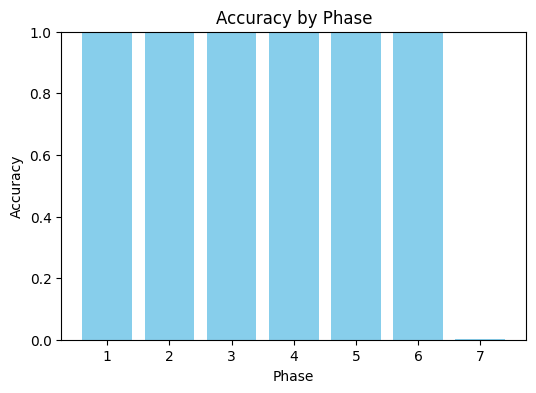

In [75]:
import matplotlib.pyplot as plt

# Accuracy values from each phase
accuracy = [1.0, 1, 1, 1, 1, 1, 0.001]

# Create the figure and bar plot
plt.figure(figsize=(6,4))
plt.bar(range(1, len(accuracy) + 1), accuracy, color='skyblue')

# Configure the axes and labels
plt.xticks(range(1, len(accuracy) + 1))  # x-axis ticks at 1..6
plt.xlabel("Phase")
plt.ylabel("Accuracy")
plt.ylim([0,1])  # optional, to keep y range from 0 to 1
plt.title("Accuracy by Phase")

plt.show()


In [1]:
print("sgsgs")

sgsgs
